# Forecast Crowd Counter

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report   
from datetime import datetime, timedelta
from typing import List, Dict, Optional  
import pytz
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
!pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable


## Dataset Load

Rute : BLOK M -> KALI BESAR

In [23]:
STOPS_NB = [
    "Blok M", "ASEAN", "Kejaksaan Agung", "Masjid Agunng", "Bundaran Senayan",
    "Gelora Bung Karno", "Polda Metro Jaya", "Bendungan Hilir", "Karet",
    "Dukuh Atas 1", "Tosari", "Bundaran HI ASTRA", "M.H Thamrin", "Kebon Sirih",
    "Monumen Nasional", "Harmoni", "Sawah Besar", "Mangga Besar",
    "Taman Sari", "Glodok", "Kota", "Museum Sejarah Jakarta", "Kali Besar"
]

STOP2IDX = {name: idx for idx, name in enumerate(STOPS_NB, start=1)}

print(STOP2IDX)


{'Blok M': 1, 'ASEAN': 2, 'Kejaksaan Agung': 3, 'Masjid Agunng': 4, 'Bundaran Senayan': 5, 'Gelora Bung Karno': 6, 'Polda Metro Jaya': 7, 'Bendungan Hilir': 8, 'Karet': 9, 'Dukuh Atas 1': 10, 'Tosari': 11, 'Bundaran HI ASTRA': 12, 'M.H Thamrin': 13, 'Kebon Sirih': 14, 'Monumen Nasional': 15, 'Harmoni': 16, 'Sawah Besar': 17, 'Mangga Besar': 18, 'Taman Sari': 19, 'Glodok': 20, 'Kota': 21, 'Museum Sejarah Jakarta': 22, 'Kali Besar': 23}


In [24]:
STOPS_SB = list(reversed(STOPS_NB))


In [25]:
BOARD_BASE_NB = {
    "Blok M": 40, "ASEAN": 30, "Kejaksaan Agung": 24, "Masjid Agunng": 36,
    "Bundaran Senayan": 30, "Gelora Bung Karno": 25, "Polda Metro Jaya": 20,
    "Bendungan Hilir": 18, "Karet": 18, "Dukuh Atas 1": 14, "Tosari": 12,
    "Bundaran HI ASTRA": 12, "M.H Thamrin": 12, "Kebon Sirih": 14,
    "Monumen Nasional": 10, "Harmoni": 14, "Sawah Besar": 16,
    "Mangga Besar": 16, "Taman Sari": 14, "Glodok": 18,
    "Kota": 20, "Museum Sejarah Jakarta": 14, "Kali Besar": 10
}


In [26]:
ALIGHT_BASE_NB = {
    "Blok M": 0, "ASEAN": 2, "Kejaksaan Agung": 2, "Masjid Agunng": 4,
    "Bundaran Senayan": 5, "Gelora Bung Karno": 6, "Polda Metro Jaya": 6,
    "Bendungan Hilir": 6, "Karet": 6, "Dukuh Atas 1": 20, "Tosari": 22,
    "Bundaran HI ASTRA": 22, "M.H Thamrin": 18, "Kebon Sirih": 15,
    "Monumen Nasional": 15, "Harmoni": 14, "Sawah Besar": 10,
    "Mangga Besar": 10, "Taman Sari": 8, "Glodok": 8,
    "Kota": 16, "Museum Sejarah Jakarta": 12, "Kali Besar": 8
}

In [27]:
BOARD_BASE_SB  = {stop: ALIGHT_BASE_NB[stop] for stop in STOPS_NB}
ALIGHT_BASE_SB = {stop: BOARD_BASE_NB[stop]  for stop in STOPS_NB}


In [28]:
def traffic_multiplier(direction: str, timestamp: datetime) -> float:
    """
    Return a multiplier for boarding/alighting counts based on time of day and day of week.
    - Morning rush (weekdays 06:00–09:00) and evening rush (weekdays 17:00–20:00)
      have higher multipliers.
    - Weekends use moderate multipliers with a small bump in the late afternoon.
    """
    hour = timestamp.hour
    weekday = timestamp.weekday()
    if weekday < 5:  # Monday–Friday
        if direction == 'NB':
            if 6 <= hour < 9:   return 1.4  # morning peak into downtown
            if 9 <= hour < 11:  return 0.7
            if 11 <= hour < 15: return 0.5
            if 15 <= hour < 17: return 0.6
            return 0.4
        else:  # SB
            if 17 <= hour < 20: return 1.3  # evening peak returning south
            if 15 <= hour < 17: return 0.7
            if 9 <= hour < 15:  return 0.6
            return 0.4
    else:  # Saturday/Sunday
        if 11 <= hour < 16: return 0.6
        if 16 <= hour < 20: return 1.3
        return 0.4

In [29]:
def dwell_time(stop: str, timestamp: datetime) -> int:
    """
    Estimate the dwell time (in seconds) at a given stop.
    Stops in the CBD (e.g., Bundaran HI ASTRA, M.H Thamrin) have longer dwell times during rush hours.
    """
    cbd_stops = {
        "Dukuh Atas 1", "Tosari", "Bundaran HI ASTRA",
        "M.H Thamrin", "Kebon Sirih", "Monumen Nasional"
    }
    hour = timestamp.hour
    base = 25 if stop in cbd_stops else 20
    if stop in cbd_stops and (6 <= hour < 9 or 17 <= hour < 20):
        base = 50  # bus queues are longer during peaks
    return base + random.randint(0, 25)

In [30]:
def travel_time(timestamp: datetime, congestion: str = "normal") -> float:
    """
    Estimate the inter‑stop travel time in minutes based on congestion level.
    - congestion = "normal": average around 3.0–3.5 minutes per segment (~1 hour total trip).
    - congestion = "heavy":  about 5.5–6.0 minutes per segment (~1.5 hours total trip).
    - congestion = "light":  about 2.5 minutes per segment (~45–50 minutes total trip).
    """
    weekday = timestamp.weekday()
    hour    = timestamp.hour
    # You can override with a congestion argument ("light", "normal", "heavy") if you wish.
    if congestion == "heavy" or ((weekday < 5) and (6 <= hour < 9 or 16 <= hour < 19)):
        base = 4.5
    elif congestion == "light":
        base = 2.5
    else:
        base = 3.5
    return base + random.uniform(-0.5, 0.5)

In [31]:
DIRECTION_MAP = {
    "NB": 0,  # BlokM → Kota
    "SB": 1   # Kota → BlokM
}

def simulate_trip(
    day: datetime, direction: str, departure: datetime,
    congestion: str = "normal", cap: int = 80
) -> list[Dict]:
    """
    Simulate a single trip; return a list of dictionaries (one per stop).
    direction: 'NB' atau 'SB'
    """
    stops      = STOPS_NB if direction == 'NB' else STOPS_SB
    board_base = BOARD_BASE_NB if direction == 'NB' else BOARD_BASE_SB
    alight_base= ALIGHT_BASE_NB if direction == 'NB' else ALIGHT_BASE_SB

    dir_num = DIRECTION_MAP[direction]

    current_time = departure
    load = 0
    trip_records = []
    for i, stop in enumerate(stops):
        arr = current_time
        dwell = dwell_time(stop, arr)
        dep  = arr + timedelta(seconds=dwell)
        mult = traffic_multiplier(direction, arr)

        board  = min(int(np.random.poisson(board_base[stop]  * mult)), cap - load)
        alight = min(int(np.random.poisson(alight_base[stop] * mult)), load)

        load_before = load
        load_after  = max(0, min(cap, load_before - alight + board))

        trip_records.append({
            "trip_date": day.date(),
            "direction": dir_num,       #  integer 0 / 1
            "stop_seq": i + 1,          # urutan halte
            "arr_time": arr.strftime("%H:%M:%S"),
            "dep_time": dep.strftime("%H:%M:%S"),
            "dwell_s": dwell,
            "board": board,
            "alight": alight,
            "load_before": load_before,
            "load_after": load_after,
            "cap": cap,
        })

        load = load_after
        if i < len(stops) - 1:
            travel_min = travel_time(arr, congestion)
            current_time = dep + timedelta(minutes=travel_min)

    return trip_records


In [32]:
def simulate_month(
    start: datetime,
    end: datetime,
    headway_minutes: int = 30,
    congestion_schedule: Optional[Dict[str, str]] = None, 
    cap: int = 80
) -> pd.DataFrame:
    """
    Generate a full month of trips.
    - start, end: timezone‑aware datetimes defining the date range (end is exclusive).
    - headway_minutes: departure frequency (e.g. every 30 minutes).
    - congestion_schedule: optional mapping of dates or weekday numbers to "light", "normal" or "heavy".
    Returns a DataFrame with all trip records.
    """
    records: List[Dict] = []
    total_days = (end.date() - start.date()).days
    for n in range(total_days):
        day = start + timedelta(days=n)

        # Determine congestion level for this day
        if congestion_schedule:
            cong = (congestion_schedule.get(day.strftime("%Y-%m-%d")) or
                    congestion_schedule.get(day.weekday()) or
                    congestion_schedule.get("weekday") or
                    "normal")
        else:
            cong = "normal"

        # loop over northbound and southbound
        for direction in ["NB", "SB"]:
            first_depart = day.replace(hour=5, minute=0, second=0, microsecond=0)
            last_depart  = day.replace(hour=21, minute=0, second=0, microsecond=0)
            depart = first_depart
            while depart <= last_depart:
                trip_data = simulate_trip(day, direction, depart, congestion=cong, cap=cap)
                records.extend(trip_data)
                depart += timedelta(minutes=headway_minutes)

    return pd.DataFrame(records)

In [21]:
tz = pytz.timezone('Asia/Jakarta')
start_date = datetime(2025, 8, 1, tzinfo=tz)
end_date   = datetime(2025, 9, 1, tzinfo=tz)

congestion_schedule = {"weekday": "normal"}  

df = simulate_month(
    start=start_date,
    end=end_date,
    headway_minutes=30,        # buses every 30 minutes
    congestion_schedule=congestion_schedule,
    cap=80                     # bus capacity
)


df.to_csv("corridor1_august_2025.csv", index=False)


In [22]:
df.head(10)

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,cap
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,80
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,80
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,80
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,80
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,80
5,2025-08-01,0,6,05:19:31,05:20:16,45,10,2,65,73,80
6,2025-08-01,0,7,05:24:02,05:24:22,20,5,0,73,78,80
7,2025-08-01,0,8,05:27:42,05:28:04,22,2,1,78,79,80
8,2025-08-01,0,9,05:31:21,05:32:02,41,1,5,79,75,80
9,2025-08-01,0,10,05:35:04,05:35:53,49,2,5,75,72,80


## EDA & Data Prep


In [33]:
print("Global descriptive statistics:")
print(df[['board','alight','load_after']].describe())


Global descriptive statistics:
              board        alight    load_after
count  47058.000000  47058.000000  47058.000000
mean       8.146968      6.745697     35.113689
std        7.093622      5.972918     27.424805
min        0.000000      0.000000      0.000000
25%        3.000000      3.000000      8.000000
50%        6.000000      5.000000     30.000000
75%       11.000000      9.000000     62.000000
max       73.000000     46.000000     80.000000


In [34]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,cap
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,80
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,80
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,80
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,80
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,80


In [340]:
"""df_copy = pd.read_csv("corridor1_august_2025.csv")

arr_dt = pd.to_datetime(df_copy['arr_time'], errors='coerce', utc=True)
dep_dt = pd.to_datetime(df_copy['dep_time_wib'], errors='coerce', utc=True)

# konversi ke timezone Asia/Jakarta (WIB)
arr_dt = arr_dt.dt.tz_convert("Asia/Jakarta")
dep_dt = dep_dt.dt.tz_convert("Asia/Jakarta")

df_copy['arr_time_wib'] = arr_dt.dt.strftime('%Y-%m-%d %H:%M:%S')
df_copy['dep_time_wib'] = dep_dt.dt.strftime('%Y-%m-%d %H:%M:%S')
"""

'df_copy = pd.read_csv("corridor1_august_2025.csv")\n\narr_dt = pd.to_datetime(df_copy[\'arr_time\'], errors=\'coerce\', utc=True)\ndep_dt = pd.to_datetime(df_copy[\'dep_time_wib\'], errors=\'coerce\', utc=True)\n\n# konversi ke timezone Asia/Jakarta (WIB)\narr_dt = arr_dt.dt.tz_convert("Asia/Jakarta")\ndep_dt = dep_dt.dt.tz_convert("Asia/Jakarta")\n\ndf_copy[\'arr_time_wib\'] = arr_dt.dt.strftime(\'%Y-%m-%d %H:%M:%S\')\ndf_copy[\'dep_time_wib\'] = dep_dt.dt.strftime(\'%Y-%m-%d %H:%M:%S\')\n'

In [35]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,cap
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,80
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,80
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,80
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,80
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,80


In [36]:
for col in ["trip_date","arr_time","dep_time"]:
    if col not in df.columns:
        df[col] = ""

arr_has = df["arr_time"].astype(str).str.match(r'^\d{1,2}:\d{2}:\d{2}$', na=False)
dep_has = df["dep_time"].astype(str).str.match(r'^\d{1,2}:\d{2}:\d{2}$', na=False)

arr_dt = pd.to_datetime(
    df.loc[arr_has, "trip_date"].astype(str) + " " + df.loc[arr_has, "arr_time"].astype(str),
    errors="coerce", format="%Y-%m-%d %H:%M:%S"
)
dep_dt = pd.to_datetime(
    df.loc[dep_has, "trip_date"].astype(str) + " " + df.loc[dep_has, "dep_time"].astype(str),
    errors="coerce", format="%Y-%m-%d %H:%M:%S"
)


base_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
base_dt.loc[arr_has] = arr_dt
fill = base_dt.isna() & dep_has
base_dt.loc[fill] = dep_dt.loc[fill]
fill2 = base_dt.isna() & df["trip_date"].notna()
base_dt.loc[fill2] = pd.to_datetime(df.loc[fill2, "trip_date"].astype(str) + " 00:00:00",
                                    errors="coerce", format="%Y-%m-%d %H:%M:%S")

df["base_dt"]    = base_dt
df["hour"]       = df["base_dt"].dt.hour.astype("Int64")
df["dow"]        = df["base_dt"].dt.dayofweek.astype("Int64")  # 0=Mon..6=Sun
df["is_weekend"] = df["dow"].isin([5,6]).astype("Int64")
df["is_workday"] = (df["is_weekend"] == 0).astype("Int64")

print("✔ base_dt built. Non-null ratio:", round(df["base_dt"].notna().mean(), 3))


✔ base_dt built. Non-null ratio: 1.0


In [37]:
for c in ["load_after","load_before","board","alight","cap","stop_seq","direction"]:
    if c not in df.columns:
        df[c] = 0

df = df.sort_values(["trip_date","direction","stop_seq","base_dt"], kind="mergesort")

grp = df.groupby(["trip_date","direction"], sort=False)

# prev_load: load_after halte sebelumnya; untuk halte pertama pakai load_before
df["prev_load"] = grp["load_after"].shift(1)
first_mask = df["stop_seq"].eq(grp["stop_seq"].transform("min"))
df.loc[first_mask, "prev_load"] = df.loc[first_mask, "load_before"]

# prior naik/turun
df["board_prior"]  = grp["board"].shift(1)
df["alight_prior"] = grp["alight"].shift(1)

# load_prior: rolling mean dari 3 langkah terakhir (berdasarkan load_after yang digeser)
tmp = grp["load_after"].shift(1)
df["load_prior"] = tmp.groupby(df["trip_date"].astype(str)+"|"+df["direction"].astype(str)) \
                      .rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

# Isi NaN -> 0 untuk fitur lag
for c in ["prev_load","board_prior","alight_prior","load_prior"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)


In [ ]:
"""import json, joblib

with open("features.json") as f:
    feats = json.load(f)

if "direction_num" in feats and "direction_num" not in df.columns and "direction" in df.columns:

    df["direction_num"] = pd.to_numeric(df["direction"], errors="coerce").fillna(0).astype(int)

missing = [c for c in feats if c not in df.columns]
for c in missing:
    df[c] = 0

for c in feats:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

X = df[feats].copy()

print("✔ features aligned. Missing filled:", missing)
"""

✔ features aligned. Missing filled: []


In [370]:
df = df.drop(columns=["stop_idx"], errors="ignore")
df = df.drop(columns=['direction_num'], errors="ignore")


In [228]:
"""# Build base_dt from trip_date + arr_time_wib (fallback dep_time_wib)
def _mk_dt(date_s, time_s):
    s = date_s.astype(str).str.strip() + " " + time_s.astype(str).str.strip()
    return pd.to_datetime(s, errors="coerce", format="%Y-%m-%d %H:%M:%S")

arr_dt = _mk_dt(df["trip_date"], df["arr_time_wib"])
dep_dt = _mk_dt(df["trip_date"], df["dep_time_wib"])
df["base_dt"] = arr_dt.fillna(dep_dt)

# Derive hour/dow
df["hour"] = df["base_dt"].dt.hour
df["dow"]  = df["base_dt"].dt.dayofweek

# Make sure we have exactly what the model wants: is_workday OR is_weekend
if "is_workday" in model_feats and "is_workday" not in df:
    df["is_workday"] = (~df["dow"].isin([5,6])).astype(int)
if "is_weekend" in model_feats and "is_weekend" not in df:
    df["is_weekend"] = (df["dow"].isin([5,6])).astype(int)
"""

In [ ]:
'''"""def parse_dt(date_col, time_col):
    """Gabungkan trip_date + jam lalu parse ke datetime lokal Asia/Jakarta."""
    # gabung string, contoh: "2025-08-01 05:00:00"
    combined = date_col.astype(str).str.strip() + " " + time_col.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', format="%Y-%m-%d %H:%M:%S")
    # lokalize ke Asia/Jakarta
    try:
        dt = dt.dt.tz_localize("Asia/Jakarta")
    except Exception:
        pass
    return dt

df['arr_dt'] = parse_dt(df['trip_date'], df['arr_time_wib'])
df['dep_dt'] = parse_dt(df['trip_date'], df['dep_time_wib'])
df['base_dt'] = df['arr_dt'].fillna(df['dep_dt'])

df['hour'] = df['base_dt'].dt.hour.astype('Int64')
df['dow'] = df['base_dt'].dt.dayofweek.astype('Int64')   # 0=Senin
df['is_weekend'] = df['dow'].isin([5,6]).astype('Int64')
if 'is_workday' not in df.columns:
    df['is_workday'] = (1 - df['is_weekend']).astype('Int64')

print("Parsed base_dt non-null ratio:", df['base_dt'].notna().mean())
display(df.head(5)[['trip_date','arr_time_wib','base_dt','hour','dow','is_weekend','is_workday']])
"""'''

Parsed base_dt non-null ratio: 0.043478260869565216


,trip_date,arr_time_wib,base_dt,hour,dow,is_weekend,is_workday
0,2025-08-01,05:00:00,2025-08-01 05:00:00+07:00,5,4,0,0
1,2025-08-01,NaN,NaT,<NA>,<NA>,0,1
2,2025-08-01,NaN,NaT,<NA>,<NA>,0,1
3,2025-08-01,NaN,NaT,<NA>,<NA>,0,1
4,2025-08-01,NaN,NaT,<NA>,<NA>,0,1


In [38]:

for col in ["load_after","load_before","board","alight","cap"]:
    if col not in df.columns:
        df[col] = 0

df = df.sort_values(["trip_date","direction","stop_seq","base_dt"], kind="mergesort")

grp = df.groupby(["trip_date","direction"], sort=False)

df["prev_load"] = grp["load_after"].shift(1)
first_mask = df["stop_seq"].eq(grp["stop_seq"].transform("min"))
df.loc[first_mask, "prev_load"] = df.loc[first_mask, "load_before"]

df["board_prior"]  = grp["board"].shift(1)
df["alight_prior"] = grp["alight"].shift(1)

# load_prior: rata2 rolling 3 halte sebelumnya (berdasarkan load_after geser 1)
tmp = grp["load_after"].shift(1)
df["load_prior"] = tmp.groupby(df["trip_date"].astype(str) + "|" + df["direction"].astype(str)) \
                      .rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

for c in ["prev_load","board_prior","alight_prior","load_prior"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).round().astype(int)

df["load_prior"] = df["load_prior"].round().astype(int)


In [39]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,cap,base_dt,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,80,2025-08-01 05:00:00,5,4,0,1,0,0,0,0
23,2025-08-01,0,1,05:30:00,05:30:45,45,13,0,0,13,80,2025-08-01 05:30:00,5,4,0,1,0,14,0,14
46,2025-08-01,0,1,06:00:00,06:00:39,39,54,0,0,54,80,2025-08-01 06:00:00,6,4,0,1,0,13,0,14
69,2025-08-01,0,1,06:30:00,06:30:21,21,47,0,0,47,80,2025-08-01 06:30:00,6,4,0,1,0,54,0,27
92,2025-08-01,0,1,07:00:00,07:00:45,45,45,0,0,45,80,2025-08-01 07:00:00,7,4,0,1,0,47,0,38


In [ ]:
"""def _clean(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    for bad in ['\xa0','\u200b','\ufeff','\t','\r','\n']:
        s = s.str.replace(bad, '', regex=False)
    return s.str.strip().replace({'nan':'','NaN':'','None':'','NULL':'','-':''})

def _fix_offset(s: pd.Series) -> pd.Series:
    # normalisasi offset ke WIB friendly
    s = s.str.replace(r'\.\d+', '', regex=True)                  # buang fractional seconds
    s = s.str.replace(r'\+07:07\b', '+07:00', regex=True)
    s = s.str.replace(r'\+0700\b', '+07:00', regex=True)
    s = s.str.replace(r'\+07(?=$)', '+07:00', regex=True)
    s = s.str.replace(r'\+07:(?!00)\d{2}\b', '+07:00', regex=True)
    s = s.str.replace(r'Z\b', '+00:00', regex=True)
    return s

arr_raw = _clean(df['arr_time'])
dep_raw = _clean(df['dep_time'])
date_raw = _clean(df['trip_date'])

# --- deteksi pola ---
arr_is_iso  = arr_raw.str.contains('T', na=False)
dep_is_iso  = dep_raw.str_contains('T', na=False) if hasattr(dep_raw, 'str_contains') else dep_raw.str.contains('T', na=False)
arr_is_hms  = (~arr_is_iso) & arr_raw.str.match(r'^\d{1,2}:\d{2}(:\d{2})?$', na=False)
dep_is_hms  = (~dep_is_iso) & dep_raw.str.match(r'^\d{1,2}:\d{2}(:\d{2})?$', na=False)
arr_is_num  = (~arr_is_iso) & pd.to_numeric(arr_raw, errors='coerce').notna()
dep_is_num  = (~dep_is_iso) & pd.to_numeric(dep_raw, errors='coerce').notna()

# --- parse ISO ---
arr_dt = pd.Series(pd.NaT, index=df.index, dtype='datetime64[ns, Asia/Jakarta]')
dep_dt = pd.Series(pd.NaT, index=df.index, dtype='datetime64[ns, Asia/Jakarta]')

if arr_is_iso.any():
    arr_iso = _fix_offset(arr_raw[arr_is_iso])
    arr_dt_iso = pd.to_datetime(arr_iso, errors='coerce', utc=True)
    try: arr_dt.loc[arr_is_iso] = arr_dt_iso.dt.tz_convert('Asia/Jakarta')
    except: pass

if dep_is_iso.any():
    dep_iso = _fix_offset(dep_raw[dep_is_iso])
    dep_dt_iso = pd.to_datetime(dep_iso, errors='coerce', utc=True)
    try: dep_dt.loc[dep_is_iso] = dep_dt_iso.dt.tz_convert('Asia/Jakarta')
    except: pass

# --- parse HH:MM(:SS) → gabung dengan trip_date ---
def _hms_to_dt(mask, raw_col):
    hhmmss = raw_col[mask].where(raw_col[mask].str.len()==8,
                                 raw_col[mask] + ':00')
    combo = date_raw[mask] + ' ' + hhmmss
    dt = pd.to_datetime(combo, errors='coerce', format='%Y-%m-%d %H:%M:%S')
    try: return dt.dt.tz_localize('Asia/Jakarta')
    except: return dt

arr_dt.loc[arr_is_hms] = _hms_to_dt(arr_is_hms, arr_raw)
dep_dt.loc[dep_is_hms] = _hms_to_dt(dep_is_hms, dep_raw)

# --- parse numeric (Excel serial / fraction) ---
def _num_to_dt(mask, raw_col):
    num = pd.to_numeric(raw_col[mask], errors='coerce')
    base = pd.Timestamp('1899-12-30')
    dt_num = base + pd.to_timedelta(num, unit='D')    # tanggal+jam (jika >1), atau hanya jam (jika <1)
    # ambil jam-menit-detik
    h, m, s = dt_num.dt.hour, dt_num.dt.minute, dt_num.dt.second
    built = pd.to_datetime(
        date_raw[mask] + ' ' +
        h.astype(str).str.zfill(2) + ':' +
        m.astype(str).str.zfill(2) + ':' +
        s.astype(str).str.zfill(2),
        errors='coerce', format='%Y-%m-%d %H:%M:%S'
    )
    try: return built.dt.tz_localize('Asia/Jakarta')
    except: return built

arr_dt.loc[arr_is_num] = _num_to_dt(arr_is_num, arr_raw)
dep_dt.loc[dep_is_num] = _num_to_dt(dep_is_num, dep_raw)

print("ARR parsed:", int(arr_dt.notna().sum()), "/", len(arr_dt))
print("DEP parsed:", int(dep_dt.notna().sum()), "/", len(dep_dt))

# --- kolom tampilan HH:MM:SS untuk UI ---
df['arr_hms'] = arr_dt.dt.strftime('%H:%M:%S').fillna('')
df['dep_hms'] = dep_dt.dt.strftime('%H:%M:%S').fillna('')

# --- kolom final jam untuk disimpan (jika kamu ingin overwrite arr_time_wib/dep_time_wib) ---
df['arr_time_wib'] = df['arr_hms']
df['dep_time_wib'] = df['dep_hms']

# --- build base_dt untuk fitur model ---
base_dt = arr_dt.copy()
base_dt.loc[base_dt.isna()] = dep_dt.loc[base_dt.isna()]

# fallback terakhir: pakai trip_date 00:00:00
mask_fallback = base_dt.isna() & date_raw.ne('')
tmp = pd.to_datetime(date_raw[mask_fallback] + ' 00:00:00', errors='coerce', format='%Y-%m-%d %H:%M:%S')
try: base_dt.loc[mask_fallback] = tmp.dt.tz_localize('Asia/Jakarta')
except: base_dt.loc[mask_fallback] = tmp

df['base_dt']    = base_dt
df['hour']       = df['base_dt'].dt.hour.astype('Int64')
df['dow']        = df['base_dt'].dt.dayofweek.astype('Int64')
df['is_weekend'] = df['dow'].isin([5,6]).astype('Int64')
df['is_workday'] = (df['is_weekend'] == 0).astype('Int64')"""

ARR parsed: 47058 / 47058
DEP parsed: 47058 / 47058


In [322]:
"""summary = (
    df.groupby(['direction','stop_name'])
      .agg(
          mean_board      = ('board', 'mean'),
          mean_alight     = ('alight', 'mean'),
          mean_load_after = ('load_after','mean')
      )
      .reset_index()
)"""

"summary = (\n    df.groupby(['direction','stop_name'])\n      .agg(\n          mean_board      = ('board', 'mean'),\n          mean_alight     = ('alight', 'mean'),\n          mean_load_after = ('load_after','mean')\n      )\n      .reset_index()\n)"

In [40]:
for direction in summary['direction'].unique():
    top = summary[summary['direction']==direction].sort_values('mean_load_after', ascending=False).head(5)
    print(f"Top stops by average load for {direction}:")
    print(top[['stop_name','mean_board','mean_alight','mean_load_after']])
    print()

NameError: name 'summary' is not defined

In [41]:
df.columns

Index(['trip_date', 'direction', 'stop_seq', 'arr_time', 'dep_time', 'dwell_s',
       'board', 'alight', 'load_before', 'load_after', 'cap', 'base_dt',
       'hour', 'dow', 'is_weekend', 'is_workday', 'prev_load', 'board_prior',
       'alight_prior', 'load_prior'],
      dtype='object')

In [377]:
def data_quality_report(df: pd.DataFrame, key_cols=('trip_date','direction','stop_seq')):
    out = {}

    #  Missing values 
    miss_cnt = df.isna().sum().sort_values(ascending=False)
    miss_pct = (df.isna().mean()*100).round(2)
    out['missing_table'] = pd.DataFrame({'missing': miss_cnt, 'pct': miss_pct})
    print("=== Missing values (count & %) ===")
    display(out['missing_table'])

    #  Parse time (for time-related checks) 
    ts = None
    if 'arr_time' in df.columns:  # time-only HH:MM:SS with trip_date present
        ts = pd.to_datetime(df['trip_date'].astype(str) + ' ' + df['arr_time'], errors='coerce')
    elif 'arr_time_wib' in df.columns:  # original ISO
        ts = pd.to_datetime(df['arr_time_wib'], errors='coerce')
    if ts is not None:
        df = df.copy()
        df['__ts'] = ts
        bad_ts = df['__ts'].isna().sum()
        print(f"\n=== Time parse check ===\nUnparsed timestamps: {bad_ts}")
        if bad_ts:
            display(df[df['__ts'].isna()].head(5)[list(set(df.columns) & set(['trip_date','arr_time_wib','arr_time','dep_time_wib','stop_name','direction']))])

    #  Duplicates 
    dup_all = df.duplicated().sum()
    print(f"\n=== Duplicates (entire row) ===\nTotal exact duplicate rows: {dup_all}")

    if all(c in df.columns for c in key_cols):
        dup_key = df.duplicated(subset=list(key_cols)).sum()
        print(f"\n=== Duplicates by key {key_cols} ===\nRows sharing the same key: {dup_key}")
        if dup_key:
            dup_rows = df[df.duplicated(subset=list(key_cols), keep=False)].sort_values(list(key_cols))
            print("Sample duplicate key rows:")
            display(dup_rows.head(10)[list(key_cols)+[c for c in ['stop_name','arr_time','arr_time_wib','dep_time_wib','board','alight','load_before','load_after'] if c in df.columns]])
    else:
        print("\n[Info] Key columns not fully present, skipping key-based duplicate check.")

    #  Basic logic checks 
    violations = []

    # Non-negative checks
    for c in ['board','alight','load_before','load_after','dwell_s','cap']:
        if c in df.columns:
            neg = (df[c] < 0).sum()
            if neg:
                violations.append((c, f'has {neg} negative values'))

    # Capacity overflow
    if {'load_after','cap'}.issubset(df.columns):
        overcap = (df['load_after'] > df['cap']).sum()
        if overcap:
            violations.append(('capacity', f'{overcap} rows with load_after > cap'))

    # Mass balance: load_after == load_before - alight + board
    if {'load_before','alight','board','load_after'}.issubset(df.columns):
        delta = df['load_before'] - df['alight'] + df['board'] - df['load_after']
        bad_bal = (delta != 0).sum()
        if bad_bal:
            violations.append(('mass_balance', f'{bad_bal} rows where load_after != load_before - alight + board'))
            print("\nExample mass-balance mismatches:")
            display(df.loc[delta != 0, ['trip_date','direction','stop_seq','stop_name','board','alight','load_before','load_after']].head(10))

    print("\n=== Logic checks ===")
    if violations:
        for name, msg in violations:
            print(f"- {name}: {msg}")
    else:
        print("No basic logic violations found.")

    return out

#  Use it
report = data_quality_report(df)


=== Missing values (count & %) ===


,missing,pct
trip_date,0,0.0
direction,0,0.0
stop_seq,0,0.0
arr_time,0,0.0
dep_time,0,0.0
dwell_s,0,0.0
board,0,0.0
alight,0,0.0
load_before,0,0.0
load_after,0,0.0



=== Time parse check ===
Unparsed timestamps: 0

=== Duplicates (entire row) ===
Total exact duplicate rows: 0

=== Duplicates by key ('trip_date', 'direction', 'stop_seq') ===
Rows sharing the same key: 45632
Sample duplicate key rows:


,trip_date,direction,stop_seq,arr_time,board,alight,load_before,load_after
0,2025-08-01,0,1,05:00:00,16,0,0,16
23,2025-08-01,0,1,05:30:00,9,0,0,9
46,2025-08-01,0,1,06:00:00,46,0,0,46
69,2025-08-01,0,1,06:30:00,56,0,0,56
92,2025-08-01,0,1,07:00:00,61,0,0,61
115,2025-08-01,0,1,07:30:00,49,0,0,49
138,2025-08-01,0,1,08:00:00,63,0,0,63
161,2025-08-01,0,1,08:30:00,50,0,0,50
184,2025-08-01,0,1,09:00:00,23,0,0,23
207,2025-08-01,0,1,09:30:00,33,0,0,33



=== Logic checks ===
No basic logic violations found.


In [42]:
is_hms_arr = df["arr_time"].astype(str).str.match(r'^\d{1,2}:\d{2}:\d{2}$', na=False)
is_hms_dep = df["dep_time"].astype(str).str.match(r'^\d{1,2}:\d{2}:\d{2}$', na=False)

arr_dt = pd.to_datetime(
    df.loc[is_hms_arr, "trip_date"].astype(str) + " " + df.loc[is_hms_arr, "arr_time"].astype(str),
    errors="coerce", format="%Y-%m-%d %H:%M:%S"
)
dep_dt = pd.to_datetime(
    df.loc[is_hms_dep, "trip_date"].astype(str) + " " + df.loc[is_hms_dep, "dep_time"].astype(str),
    errors="coerce", format="%Y-%m-%d %H:%M:%S"
)

ts = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
ts.loc[is_hms_arr] = arr_dt
ts.loc[ts.isna() & is_hms_dep] = dep_dt.loc[ts.isna() & is_hms_dep]
ts.loc[ts.isna()] = pd.to_datetime(df.loc[ts.isna(), "trip_date"].astype(str) + " 00:00:00",
                                   errors="coerce", format="%Y-%m-%d %H:%M:%S")

df["timestamp"]  = ts
df["hour"]       = df["timestamp"].dt.hour.astype("Int64")
df["dow"]        = df["timestamp"].dt.dayofweek.astype("Int64")
df["is_weekend"] = (df["dow"] >= 5).astype("Int64")
df["is_workday"] = (df["is_weekend"] == 0).astype("Int64")


In [43]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,base_dt,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,2025-08-01 05:00:00,5,4,0,1,0,0,0,0,2025-08-01 05:00:00
23,2025-08-01,0,1,05:30:00,05:30:45,45,13,0,0,13,...,2025-08-01 05:30:00,5,4,0,1,0,14,0,14,2025-08-01 05:30:00
46,2025-08-01,0,1,06:00:00,06:00:39,39,54,0,0,54,...,2025-08-01 06:00:00,6,4,0,1,0,13,0,14,2025-08-01 06:00:00
69,2025-08-01,0,1,06:30:00,06:30:21,21,47,0,0,47,...,2025-08-01 06:30:00,6,4,0,1,0,54,0,27,2025-08-01 06:30:00
92,2025-08-01,0,1,07:00:00,07:00:45,45,45,0,0,45,...,2025-08-01 07:00:00,7,4,0,1,0,47,0,38,2025-08-01 07:00:00


In [44]:
df = df.sort_values(["trip_date","direction","timestamp","stop_seq"], kind="mergesort").reset_index(drop=True)


In [45]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,base_dt,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,2025-08-01 05:00:00,5,4,0,1,0,0,0,0,2025-08-01 05:00:00
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,2025-08-01 05:03:46,5,4,0,1,25,25,0,21,2025-08-01 05:03:46
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,2025-08-01 05:07:30,5,4,0,1,34,11,2,33,2025-08-01 05:07:30
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,2025-08-01 05:11:14,5,4,0,1,38,5,1,39,2025-08-01 05:11:14
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,2025-08-01 05:15:13,5,4,0,1,51,15,2,51,2025-08-01 05:15:13


In [46]:
keys = ['direction','stop_seq','hour']
g    = df.groupby(keys, sort=False)


In [47]:
df["load_prior"]   = g["load_after"].transform(lambda s: s.shift().expanding().mean())
df["board_prior"]  = g["board"]     .transform(lambda s: s.shift().expanding().mean())
df["alight_prior"] = g["alight"]    .transform(lambda s: s.shift().expanding().mean())

df["load_prior"]   = df["load_prior"]  .fillna(g["load_after"].transform("mean"))
df["board_prior"]  = df["board_prior"] .fillna(g["board"]     .transform("mean"))
df["alight_prior"] = df["alight_prior"].fillna(g["alight"]    .transform("mean"))

for c in ["load_prior","board_prior","alight_prior"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)


In [48]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,base_dt,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,2025-08-01 05:00:00,5,4,0,1,0,16.129032,0.000000,16.129032,2025-08-01 05:00:00
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,2025-08-01 05:03:46,5,4,0,1,25,12.709677,0.677419,28.161290,2025-08-01 05:03:46
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,2025-08-01 05:07:30,5,4,0,1,34,9.241935,0.758065,36.645161,2025-08-01 05:07:30
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,2025-08-01 05:11:14,5,4,0,1,38,14.822581,1.532258,49.935484,2025-08-01 05:11:14
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,2025-08-01 05:15:13,5,4,0,1,51,11.645161,2.370968,59.209677,2025-08-01 05:15:13


In [49]:
keys = ['direction','stop_seq','hour']
g    = df.groupby(keys, sort=False)

# Expanding means with SHIFT so each row uses only PAST info in its group
df['load_prior']   = g['load_after'].transform(lambda s: s.shift().expanding().mean())
df['board_prior']  = g['board']     .transform(lambda s: s.shift().expanding().mean())
df['alight_prior'] = g['alight']    .transform(lambda s: s.shift().expanding().mean())

# Fallback for the first occurrences in each group
df['load_prior']   = df['load_prior']  .fillna(g['load_after'].transform('mean'))
df['board_prior']  = df['board_prior'] .fillna(g['board']     .transform('mean'))
df['alight_prior'] = df['alight_prior'].fillna(g['alight']    .transform('mean'))

# On-trip state: previous stop's load within the same (trip_date, direction)
df = df.sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)
df['prev_load'] = (
    df.groupby(['trip_date','direction'])['load_after']
      .shift(1)
      .fillna(df['load_before'])
      .clip(lower=0)
)

# Optional peak flags
df['is_peak_am'] = ((df['hour'] >= 6) & (df['hour'] <= 9)).astype(int)
df['is_peak_pm'] = ((df['hour'] >= 17) & (df['hour'] <= 20)).astype(int)


In [50]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,is_peak_am,is_peak_pm
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,0,0
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,0,0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,0,0
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,0,0
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,0,0


In [51]:
df = df.sort_values(["trip_date","direction","timestamp","stop_seq"], kind="mergesort").reset_index(drop=True)
df["prev_load"] = (
    df.groupby(["trip_date","direction"])["load_after"]
      .shift(1)
      .fillna(df["load_before"])
      .clip(lower=0)
)

# Optional peak flags
df["is_peak_am"] = ((df["hour"] >= 6) & (df["hour"] <= 9)).astype(int)
df["is_peak_pm"] = ((df["hour"] >= 17) & (df["hour"] <= 20)).astype(int)


In [52]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,is_peak_am,is_peak_pm
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,0,0
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,0,0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,0,0
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,0,0
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,0,0


In [53]:
# Pastikan numerik dasar
for c in ["board","alight","load_before","load_after","cap","dwell_s","stop_seq","direction"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


In [54]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,is_peak_am,is_peak_pm
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,0,0
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,0,0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,0,0
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,0,0
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,0,0


In [55]:
from sklearn.metrics import mean_absolute_error

keys_base = ['direction','stop_seq','hour','dow']
hist_mean = (df.groupby(keys_base)['load_after']
               .mean().reset_index()
               .rename(columns={'load_after':'baseline_mean'}))
df = df.merge(hist_mean, on=keys_base, how='left')

# Split last 7 days
all_dates = sorted(df['trip_date'].dropna().unique())
split_date = all_dates[-7] if len(all_dates) >= 7 else all_dates[max(0, len(all_dates)-1)]
is_train = df['trip_date'] <  split_date
is_test  = df['trip_date'] >= split_date

y_true = df.loc[is_test, 'load_after']
y_base = df.loc[is_test, 'baseline_mean'].clip(0, df.loc[is_test,'cap'])
print("Baseline MAE:", mean_absolute_error(y_true, y_base))


Baseline MAE: 4.724154295836961


In [56]:
priors_table = (
    df.groupby(['direction','stop_seq','hour'])[['board_prior','alight_prior','load_prior']]
      .mean().reset_index()
)
priors_table.to_csv('priors_lookup.csv', index=False)

order_nb = (df[df['direction']==0]
            .sort_values('stop_seq')['stop_seq'].drop_duplicates().tolist())
order_sb = (df[df['direction']==1]
            .sort_values('stop_seq')['stop_seq'].drop_duplicates().tolist())

pd.Series(order_nb).to_csv('stops_nb.csv', index=False, header=False)
pd.Series(order_sb).to_csv('stops_sb.csv', index=False, header=False)


In [57]:
df.head(10)

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,is_peak_am,is_peak_pm,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,0,0,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,0,0,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,0,0,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,0,0,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,0,0,58.6
5,2025-08-01,0,6,05:19:31,05:20:16,45,10,2,65,73,...,0,1,65.0,8.741935,2.790323,65.161290,2025-08-01 05:19:31,0,0,64.5
6,2025-08-01,0,7,05:24:02,05:24:22,20,5,0,73,78,...,0,1,73.0,6.935484,2.467742,69.629032,2025-08-01 05:24:02,0,0,69.5
7,2025-08-01,0,8,05:27:42,05:28:04,22,2,1,78,79,...,0,1,78.0,5.426230,2.180328,72.901639,2025-08-01 05:27:42,0,0,72.1
8,2025-08-01,0,1,05:30:00,05:30:45,45,13,0,0,13,...,0,1,79.0,14.000000,0.000000,14.000000,2025-08-01 05:30:00,0,0,15.6
9,2025-08-01,0,9,05:31:21,05:32:02,41,1,5,79,75,...,0,1,13.0,3.451613,2.290323,75.870968,2025-08-01 05:31:21,0,0,75.8


In [58]:
df = df.drop(columns=['is_peak_am','is_peak_pm'], errors='ignore')

In [59]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [ ]:
import joblib
import numpy as np
from datetime import datetime
import pytz

rf_loaded = joblib.load('model_load_after.joblib')
priors    = pd.read_csv('priors_lookup.csv')
stops_nb  = pd.read_csv('stops_nb.csv', header=None)[0].tolist()
stops_sb  = pd.read_csv('stops_sb.csv', header=None)[0].tolist()

def forecast_downstream(origin_stop_seq: int, current_load: float, direction_num: int,
                        now_ts=None, cap=80, features=None) -> list[dict]:
    """
    origin_stop_seq: int (mis. 12)
    direction_num: 0=NB, 1=SB
    """
    if now_ts is None:
        now_ts = datetime.now(pytz.timezone('Asia/Jakarta'))
    hour = now_ts.hour
    dow  = now_ts.weekday()
    is_weekend = int(dow >= 5)

    order = stops_nb if int(direction_num) == 0 else stops_sb
    if origin_stop_seq not in order:
        raise ValueError(f'Unknown origin_stop_seq: {origin_stop_seq}')

    idx0 = order.index(origin_stop_seq)
    seqs = order[idx0:]  # termasuk origin

    load = float(current_load)
    out  = []

    for stop_seq in seqs:
        # ambil prior untuk (direction, stop_seq, hour)
        pr_row = priors[(priors.direction==direction_num) &
                        (priors.stop_seq==stop_seq) &
                        (priors.hour==hour)]
        if pr_row.empty:
            pr = {'board_prior':0.0, 'alight_prior':0.0, 'load_prior':load}
        else:
            pr = pr_row.iloc[0].to_dict()

        row = pd.DataFrame([{
            'hour': int(hour), 'dow': int(dow), 'is_weekend': is_weekend,
            'direction_num': int(direction_num),
            'prev_load': float(load),
            'load_prior': float(pr['load_prior']),
            'board_prior': float(pr['board_prior']),
            'alight_prior': float(pr['alight_prior']),
            # optional engineered flags jika model pakai:
            'is_workday': int(1-is_weekend),
            #'is_peak_am': int(6<=hour<=9),
            #'is_peak_pm': int(17<=hour<=20),
            # tambahkan fitur lain sesuai features.json
        }])

        # align kolom sesuai features.json
        if features is None:
            import json
            with open("features.json") as f:
                features = json.load(f)
        for c in features:
            if c not in row.columns:
                row[c] = 0
        row = row[features].apply(pd.to_numeric, errors="coerce").fillna(0)

        pred = float(rf_loaded.predict(row)[0])
        load = max(0, min(cap, pred))  # update state untuk halte berikut
        out.append({'stop_seq': int(stop_seq), 'forecast_load_after': int(round(load))})

    return out

# contoh:
# forecast_downstream(origin_stop_seq=12, current_load=42, direction_num=1)


### Train & Test df

In [ ]:
"""# ==== 0) IMPORTS ====
import os, json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

MODEL_PATH = "model_load_after_HistGBDT.joblib"
FEATURES_PATH = "features.json"
PRIORS_PATH = "priors_lookup.csv"
STOPS_NB_PATH = "stops_nb.csv"
STOPS_SB_PATH = "stops_sb.csv"
DWELL_H_PATH  = "dwell_lookup_h.csv"
DWELL_WE_PATH = "dwell_lookup_we.csv"
DWELL_SX_PATH = "dwell_lookup_sx.csv"
"""

In [63]:
FEATURES_BASE = [
    'hour','dow','is_weekend','direction',
    'prev_load','load_prior','board_prior','alight_prior'   # ← tanpa dwell_s
]
FEATS  = [f for f in FEATURES_BASE if f in train_df.columns and f in test_df.columns]


In [64]:
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib, json

best_model = HistGradientBoostingRegressor(random_state=42).fit(train_df[FEATS], train_df['load_after'].astype(float))
joblib.dump(best_model, "model_load_after_HistGBDT.joblib")

with open("features.json","w") as f:
    json.dump(FEATS, f)


In [65]:
rf_loaded = joblib.load("model_load_after_HistGBDT.joblib")
priors    = pd.read_csv("priors_lookup.csv")
stops_nb  = pd.read_csv("stops_nb.csv", header=None)[0].tolist()
stops_sb  = pd.read_csv("stops_sb.csv", header=None)[0].tolist()

def forecast_downstream(origin_stop_seq: int, current_load: float, direction_num: int,
                        now_ts=None, cap=80, features=None) -> list[dict]:
    from datetime import datetime
    import pytz, json
    import pandas as pd
    import numpy as np

    if now_ts is None:
        now_ts = datetime.now(pytz.timezone('Asia/Jakarta'))
    hour = now_ts.hour
    dow  = now_ts.weekday()
    is_weekend = int(dow >= 5)

    order = stops_nb if int(direction_num) == 0 else stops_sb
    if origin_stop_seq not in order:
        raise ValueError(f"Unknown origin_stop_seq: {origin_stop_seq}")
    seqs = order[order.index(origin_stop_seq):]

    if features is None:
        with open("features.json") as f:
            features = json.load(f)

    load = float(current_load)
    out  = []
    for stop_seq in seqs:
        pr_row = priors[(priors.direction==direction_num) &
                        (priors.stop_seq==stop_seq) &
                        (priors.hour==hour)]
        if pr_row.empty:
            pr = {'board_prior':0.0,'alight_prior':0.0,'load_prior':load}
        else:
            pr = pr_row.iloc[0].to_dict()

        row = pd.DataFrame([{
            'hour': int(hour),
            'dow': int(dow),
            'is_weekend': is_weekend,
            'direction': int(direction_num),   # pakai kolom 'direction' (int)
            'prev_load': float(load),
            'load_prior': float(pr['load_prior']),
            'board_prior': float(pr['board_prior']),
            'alight_prior': float(pr['alight_prior']),
        }])

        # align ke features.json
        for c in features:
            if c not in row.columns:
                row[c] = 0
        row = row[features].apply(pd.to_numeric, errors="coerce").fillna(0)

        pred = float(rf_loaded.predict(row)[0])
        load = max(0, min(cap, pred))
        out.append({'stop_seq': int(stop_seq), 'forecast_load_after': int(round(load))})

    return out


In [60]:
all_dates  = sorted(df['trip_date'].dropna().unique())
split_date = all_dates[-7]  # last 7 days as test

train_df = df[df['trip_date'] <  split_date].copy()
test_df  = df[df['trip_date'] >= split_date].copy()


In [ ]:
"""# === Dwell lookup (TRAIN only) ===
# granular utama: direction, stop_seq, hour
dwell_h = (train_df.groupby(['direction','stop_seq','hour'])['dwell_s']
           .mean().reset_index().rename(columns={'dwell_s':'dwell_h'}))

# fallback weekend/weekday
dwell_we = (train_df.assign(is_weekend=(train_df['base_dt'].dt.dayofweek>=5).astype(int))
            .groupby(['direction','stop_seq','is_weekend'])['dwell_s']
            .mean().reset_index().rename(columns={'dwell_s':'dwell_we'}))

# fallback paling kasar: per (direction, stop_seq) saja
dwell_sx = (train_df.groupby(['direction','stop_seq'])['dwell_s']
            .mean().reset_index().rename(columns={'dwell_s':'dwell_sx'}))

# simpan semua untuk dipakai saat inference
dwell_h.to_csv('dwell_lookup_h.csv', index=False)
dwell_we.to_csv('dwell_lookup_we.csv', index=False)
dwell_sx.to_csv('dwell_lookup_sx.csv', index=False)
"""

In [ ]:
"""import joblib, json, pandas as pd
import numpy as np
from datetime import datetime
import pytz

rf_loaded = joblib.load('model_load_after.joblib')
priors    = pd.read_csv('priors_lookup.csv')
stops_nb  = pd.read_csv('stops_nb.csv', header=None)[0].tolist()
stops_sb  = pd.read_csv('stops_sb.csv', header=None)[0].tolist()

# load dwell lookups (opsional; ada fallback kalau file tidak ada)
try:
    dwell_h  = pd.read_csv('dwell_lookup_h.csv')   # cols: direction, stop_seq, hour, dwell_h
    dwell_we = pd.read_csv('dwell_lookup_we.csv')  # cols: direction, stop_seq, is_weekend, dwell_we
    dwell_sx = pd.read_csv('dwell_lookup_sx.csv')  # cols: direction, stop_seq, dwell_sx
except Exception:
    dwell_h = dwell_we = dwell_sx = None

def _get_dwell(direction:int, stop_seq:int, hour:int, is_weekend:int) -> float:
    """Ambil dwell_s dari lookup dengan hirarki fallback."""
    # 1) by (dir, stop, hour)
    if dwell_h is not None:
        m = ((dwell_h.direction==direction) &
             (dwell_h.stop_seq==stop_seq) &
             (dwell_h.hour==hour))
        if m.any():
            return float(dwell_h.loc[m, 'dwell_h'].iloc[0])

    # 2) by (dir, stop, is_weekend)
    if dwell_we is not None:
        m = ((dwell_we.direction==direction) &
             (dwell_we.stop_seq==stop_seq) &
             (dwell_we.is_weekend==is_weekend))
        if m.any():
            return float(dwell_we.loc[m, 'dwell_we'].iloc[0])

    # 3) by (dir, stop)
    if dwell_sx is not None:
        m = ((dwell_sx.direction==direction) &
             (dwell_sx.stop_seq==stop_seq))
        if m.any():
            return float(dwell_sx.loc[m, 'dwell_sx'].iloc[0])

    # 4) default
    return 30.0  # default aman

def forecast_downstream(origin_stop_seq: int, current_load: float, direction_num: int,
                        now_ts=None, cap=80, features=None) -> list[dict]:
    """
    Prediksi load_after berturut-turut mulai origin_stop_seq sampai akhir rute.
    - direction_num: 0=NB, 1=SB
    - features: list fitur sesuai features.json (opsional; kalau None, dibaca dari file)
    """
    if now_ts is None:
        now_ts = datetime.now(pytz.timezone('Asia/Jakarta'))
    hour = now_ts.hour
    dow  = now_ts.weekday()
    is_weekend = int(dow >= 5)

    order = stops_nb if int(direction_num) == 0 else stops_sb
    if origin_stop_seq not in order:
        raise ValueError(f'Unknown origin_stop_seq: {origin_stop_seq}')

    idx0 = order.index(origin_stop_seq)
    seqs = order[idx0:]  # termasuk origin

    # siapkan daftar fitur
    if features is None:
        with open("features.json") as f:
            features = json.load(f)

    load = float(current_load)
    out  = []

    for stop_seq in seqs:
        # priors untuk (direction, stop_seq, hour)
        pr_row = priors[(priors.direction==direction_num) &
                        (priors.stop_seq==stop_seq) &
                        (priors.hour==hour)]
        if pr_row.empty:
            pr = {'board_prior':0.0, 'alight_prior':0.0, 'load_prior':load}
        else:
            pr = pr_row.iloc[0].to_dict()

        # siapkan dwell_s dari lookup
        dwell_val = _get_dwell(int(direction_num), int(stop_seq), int(hour), is_weekend)

        # bangun row fitur
        row = pd.DataFrame([{
            'hour': int(hour),
            'dow': int(dow),
            'is_weekend': is_weekend,
            'direction': int(direction_num),        # pakai 'direction' (int)
            'direction_num': int(direction_num),    # tetap isi juga jika model lama butuh
            'prev_load': float(load),
            'load_prior': float(pr['load_prior']),
            'board_prior': float(pr['board_prior']),
            'alight_prior': float(pr['alight_prior']),
            'dwell_s': float(dwell_val),
            'is_workday': int(1 - is_weekend),
        }])

        # align dengan features.json (kolom yang tidak ada → 0)
        for c in features:
            if c not in row.columns:
                row[c] = 0
        row = row[features].apply(pd.to_numeric, errors="coerce").fillna(0)

        # prediksi + update state
        pred = float(rf_loaded.predict(row)[0])
        load = max(0, min(cap, pred))
        out.append({'stop_seq': int(stop_seq), 'forecast_load_after': int(round(load))})

    return out
"""

In [66]:
import json
with open("features.json") as f:
    model_feats = json.load(f)

missing = [c for c in model_feats if c not in df.columns]
print("MISSING in df:", missing)

key_cols = [c for c in model_feats if c.lower() in (
    "hour","dow","is_workday","is_weekend","direction_num",
    "prev_load","load_prior","board_prior","alight_prior","cap"
)]
print({c: int((pd.to_numeric(df[c], errors='coerce').fillna(0) != 0).sum()) for c in key_cols if c in df})


MISSING in df: []
{'hour': 47058, 'dow': 40986, 'is_weekend': 15180, 'prev_load': 45150, 'load_prior': 46074, 'board_prior': 46005, 'alight_prior': 44960}


In [396]:
import json
with open("features.json") as f:
    model_feats = json.load(f)

missing = [c for c in model_feats if c not in df.columns]
print("MISSING in df:", missing)

key_cols = [c for c in model_feats if c.lower() in (
    "hour","dow","is_workday","is_weekend","direction_num",
    "prev_load","load_prior","board_prior","alight_prior","cap"
)]
print({c: int((pd.to_numeric(df[c], errors='coerce').fillna(0) != 0).sum()) for c in key_cols if c in df})


MISSING in df: []
{'hour': 47058, 'dow': 40986, 'is_weekend': 15180, 'direction_num': 23529, 'prev_load': 45166, 'load_prior': 46020, 'board_prior': 46011, 'alight_prior': 44965}


In [ ]:
"""from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    out = 2.0 * np.abs(y_pred - y_true) / np.where(denom==0, 1.0, denom)
    return np.nanmean(out)

def make_time_folds(df: pd.DataFrame, n_folds=3, min_train_days=14, test_days=3):
    """Return list of (train_idx, val_idx) boolean masks using unique dates."""
    dates = sorted(df['trip_date'].dropna().unique())
    folds = []
    # Rolling windows from older to newer
    for k in range(n_folds):
        end_val   = len(dates) - k*test_days
        start_val = max(0, end_val - test_days)
        end_tr    = max(0, start_val - 0)
        start_tr  = max(0, end_tr - min_train_days)
        if start_tr >= end_tr or start_val >= end_val: 
            continue
        tr_dates = set(dates[start_tr:end_tr])
        va_dates = set(dates[start_val:end_val])
        train_idx = df['trip_date'].isin(tr_dates).values
        val_idx   = df['trip_date'].isin(va_dates).values
        if train_idx.sum() and val_idx.sum():
            folds.append((train_idx, val_idx, (dates[start_tr], dates[end_tr-1]), (dates[start_val], dates[end_val-1])))
    folds = folds[::-1]  # oldest→newest
    return folds

# Build folds
N_FOLDS = 3       # bump to 4–5 later
MIN_TR_DAYS = 14  # ensure enough history
TEST_DAYS   = 3
folds = make_time_folds(df, n_folds=N_FOLDS, min_train_days=MIN_TR_DAYS, test_days=TEST_DAYS)
print(f"{len(folds)} folds built.")
"""

In [ ]:
"""def build_timestamp(df: pd.DataFrame) -> pd.Series:
    if 'arr_time' in df.columns and df['arr_time'].astype(str).str.contains(':', na=False).all():
        return pd.to_datetime(df['trip_date'].astype(str) + ' ' + df['arr_time'],
                              format='%Y-%m-%d %H:%M:%S', errors='coerce')
    s = df['arr_time_wib'].astype(str)
    time_only = np.where(s.str.contains('T', na=False), s.str.slice(11, 19), s)
    return pd.to_datetime(df['trip_date'].astype(str) + ' ' + time_only,
                          format='%Y-%m-%d %H:%M:%S', errors='coerce')

df['timestamp'] = build_timestamp(df)
df['trip_date'] = pd.to_datetime(df['trip_date'], errors='coerce').dt.date

# numeric and time features
for c in ['board','alight','load_before','load_after','cap','dwell_s','stop_seq']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df['hour']       = pd.to_datetime(df['timestamp']).dt.hour
df['dow']        = pd.to_datetime(df['timestamp']).dt.dayofweek
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['direction_num'] = df['direction'].map({'BlokM→Kota':0,'Kota→BlokM':1}).astype(int)

df = df.sort_values(['direction','stop_name','hour','trip_date','timestamp']).reset_index(drop=True)
"""

In [ ]:
"""import json, pandas as pd

with open("features.json") as f:
    model_feats = json.load(f)

print("Model needs:", len(model_feats), "features")
print(model_feats)

# Apakah semua tersedia di df?
missing = [c for c in model_feats if c not in df.columns]
extra   = [c for c in df.columns if c in model_feats and df[c].isna().all()]
print("\nMISSING in df:", missing)
print("ALL-NaN in df (will become zeros):", extra)

# Lihat distribusi nilai fitur-fitur kunci
key_cols = [c for c in model_feats if c.lower() in ("hour","dow","is_workday","is_weekend",
                                                    "direction_num","prev_load","load_prior",
                                                    "board_prior","alight_prior","cap")]
print("\nKey cols we care about:")
print(key_cols)

print("\nNon-zero counts (should NOT be all zeros):")
print({c: int((pd.to_numeric(df[c], errors='coerce').fillna(0) != 0).sum()) for c in key_cols if c in df})
"""

Model needs: 10 features
['stop_idx', 'hour', 'dow', 'is_weekend', 'direction_num', 'prev_load', 'load_prior', 'board_prior', 'alight_prior', 'dwell_s']

MISSING in df: ['stop_idx', 'hour', 'dow', 'is_weekend', 'direction_num', 'prev_load', 'load_prior', 'board_prior', 'alight_prior']
ALL-NaN in df (will become zeros): []

Key cols we care about:
['hour', 'dow', 'is_weekend', 'direction_num', 'prev_load', 'load_prior', 'board_prior', 'alight_prior']

Non-zero counts (should NOT be all zeros):
{}


In [67]:
keys_dow = ['direction','stop_seq','hour','dow']
keys_we  = ['direction','stop_seq','hour','is_weekend']
keys_hr  = ['direction','stop_seq','hour']


In [68]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [69]:
g = train_df.groupby(keys_dow, sort=False)

def make_prior(train, col, outname):
    prior = g[col].transform(lambda s: s.shift().expanding().mean())
    prior = prior.fillna(g[col].transform('mean'))
    train[outname] = prior

make_prior(train_df, 'load_after', 'load_prior')
make_prior(train_df, 'board',      'board_prior')
make_prior(train_df, 'alight',     'alight_prior')


In [70]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [71]:
priors_dow = (train_df.groupby(keys_dow)[['board_prior','alight_prior','load_prior']]
              .mean().reset_index())

priors_we = (train_df.groupby(keys_we)[['board_prior','alight_prior','load_prior']]
             .mean().reset_index()
             .rename(columns={'board_prior':'board_prior_we',
                              'alight_prior':'alight_prior_we',
                              'load_prior':'load_prior_we'}))

priors_hr = (train_df.groupby(keys_hr)[['board_prior','alight_prior','load_prior']]
             .mean().reset_index()
             .rename(columns={'board_prior':'board_prior_hr',
                              'alight_prior':'alight_prior_hr',
                              'load_prior':'load_prior_hr'}))


In [72]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [73]:
test_df = test_df.drop(columns=['board_prior','alight_prior','load_prior'], errors='ignore')

test_df = test_df.merge(priors_dow, on=keys_dow, how='left', validate='m:1')
test_df = test_df.merge(priors_we,  on=keys_we,  how='left', validate='m:1')
test_df = test_df.merge(priors_hr,  on=keys_hr,  how='left', validate='m:1')

test_df['board_prior']  = (test_df['board_prior']
                           .fillna(test_df['board_prior_we'])
                           .fillna(test_df['board_prior_hr'])
                           .fillna(0.0))
test_df['alight_prior'] = (test_df['alight_prior']
                           .fillna(test_df['alight_prior_we'])
                           .fillna(test_df['alight_prior_hr'])
                           .fillna(0.0))
test_df['load_prior']   = (test_df['load_prior']
                           .fillna(test_df['load_prior_we'])
                           .fillna(test_df['load_prior_hr'])
                           .fillna(test_df['load_before']))

test_df = test_df.drop(columns=[
    'board_prior_we','alight_prior_we','load_prior_we',
    'board_prior_hr','alight_prior_hr','load_prior_hr'
], errors='ignore')


In [74]:
test_df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,timestamp,baseline_mean,board_prior,alight_prior,load_prior
0,2025-08-25,0,1,05:00:00,05:00:34,34,21,0,0,21,...,5,0,0,1,0.0,2025-08-25 05:00:00,17.000,17.022222,0.000000,17.022222
1,2025-08-25,0,2,05:04:27,05:04:48,21,9,0,21,30,...,5,0,0,1,21.0,2025-08-25 05:04:27,28.625,12.436111,0.163889,29.294444
2,2025-08-25,0,3,05:08:46,05:09:20,34,8,0,30,38,...,5,0,0,1,30.0,2025-08-25 05:08:46,38.625,11.500000,0.813889,39.980556
3,2025-08-25,0,4,05:12:51,05:13:20,29,11,2,38,47,...,5,0,0,1,38.0,2025-08-25 05:12:51,50.625,13.522222,1.455556,52.047222
4,2025-08-25,0,5,05:16:57,05:17:30,33,12,6,47,53,...,5,0,0,1,47.0,2025-08-25 05:16:57,62.875,17.675000,2.255556,67.466667


In [75]:
train_df = train_df.sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)
test_df  = test_df .sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)

train_df['prev_load'] = (
    train_df.groupby(['trip_date','direction'])['load_after']
            .shift(1).fillna(train_df['load_before']).clip(lower=0)
)
# untuk test, simpan kolom terpisah prev_load_tf (true-forward dari data test sendiri)
test_df['prev_load_tf'] = (
    test_df.groupby(['trip_date','direction'])['load_after']
           .shift(1).fillna(test_df['load_before']).clip(lower=0)
)


In [76]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

base_keys = ['direction','stop_seq','hour','dow']
_hist = (train_df.groupby(base_keys)['load_after'].mean()
         .reset_index().rename(columns={'load_after':'baseline_mean'}))

tb = test_df.merge(_hist, on=base_keys, how='left')
y_true = tb['load_after'].astype(float)
# Use the correct baseline_mean column (try 'baseline_mean_x', fallback to 'baseline_mean_y')
if 'baseline_mean_x' in tb.columns:
    y_base = tb['baseline_mean_x'].astype(float).fillna(y_true.mean())
elif 'baseline_mean_y' in tb.columns:
    y_base = tb['baseline_mean_y'].astype(float).fillna(y_true.mean())
else:
    raise KeyError("No baseline_mean column found in tb DataFrame.")

y_base = y_base.clip(lower=0, upper=tb['cap'].astype(float))

print("Baseline MAE :", mean_absolute_error(y_true, y_base))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_true, y_base)))


Baseline MAE : 4.724154295836961
Baseline RMSE: 6.88220631194598


In [78]:
FEATURES_BASE = [
    'hour','dow','is_weekend','direction_num',
    'prev_load','load_prior','board_prior','alight_prior','dwell_s'
]



FEATS  = [f for f in FEATURES_BASE if f in train_df.columns and f in test_df.columns]
TARGET = 'load_after'


In [79]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [406]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

models = {
    'Linear':       Pipeline([('scaler', StandardScaler(with_mean=False)), ('lr', LinearRegression())]),
    'Ridge':        Pipeline([('scaler', StandardScaler(with_mean=False)), ('rg', Ridge(alpha=1.0))]),
    'Lasso':        Pipeline([('scaler', StandardScaler(with_mean=False)), ('ls', Lasso(alpha=0.001, max_iter=10000))]),
    'ElasticNet':   Pipeline([('scaler', StandardScaler(with_mean=False)), ('en', ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000))]),
    'RandomForest': RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    'GBDT':         GradientBoostingRegressor(random_state=42),
    'HistGBDT':     HistGradientBoostingRegressor(random_state=42)
}
try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist'
    )
except Exception:
    pass

def rollout_predict(model, test_df, feats, cap_col='cap'):
    preds = []
    for (dte, direc), grp in test_df.groupby(['trip_date','direction'], sort=True):
        grp = grp.sort_values(['timestamp','stop_seq']).copy()
        state_prev = float(grp.iloc[0]['load_before'])
        for _, r in grp.iterrows():
            row = r.copy()
            row['prev_load'] = state_prev
            X_row = pd.DataFrame([row])[feats]
            yhat  = float(model.predict(X_row)[0])
            yhat  = max(0, min(float(r[cap_col]), yhat))
            preds.append(yhat)
            state_prev = yhat
    return np.array(preds)

rows = []
X_tr, y_tr = train_df[FEATS], train_df[TARGET].astype(float)

for name, mdl in models.items():
    mdl.fit(X_tr, y_tr)

    # teacher-forced (pakai prev_load_tf di test)
    X_te_tf = test_df.assign(prev_load=test_df['prev_load_tf'])[FEATS]
    pred_tf = np.clip(mdl.predict(X_te_tf), 0, test_df['cap'].astype(float))
    mae_tf  = mean_absolute_error(test_df[TARGET].astype(float), pred_tf)
    rmse_tf = np.sqrt(mean_squared_error(test_df[TARGET].astype(float), pred_tf))

    # rollout (pakai state dari prediksi sebelumnya)
    pred_roll = rollout_predict(mdl, test_df, FEATS)
    mae_roll  = mean_absolute_error(test_df[TARGET].astype(float), pred_roll)
    rmse_roll = np.sqrt(mean_squared_error(test_df[TARGET].astype(float), pred_roll))

    rows.append({'model': name,
                 'MAE_TF': mae_tf, 'RMSE_TF': rmse_tf,
                 'MAE_ROLL': mae_roll, 'RMSE_ROLL': rmse_roll})

leaderboard = pd.DataFrame(rows).sort_values('MAE_ROLL')
print("\n=== Leaderboard (sorted by MAE_ROLL) ===")
print(leaderboard.to_string(index=False))

best_name  = leaderboard.iloc[0]['model']
best_model = models[best_name]
print("\nBest by rollout:", best_name)



=== Leaderboard (sorted by MAE_ROLL) ===
       model   MAE_TF  RMSE_TF  MAE_ROLL  RMSE_ROLL
    HistGBDT 5.314914 7.615308  5.325256   7.631741
        GBDT 5.346191 7.612594  5.346663   7.623654
RandomForest 5.404823 7.787893  5.400936   7.790365
      Linear 5.448099 7.729404  5.445091   7.725679
       Ridge 5.448287 7.729474  5.445281   7.725748
       Lasso 5.448223 7.729407  5.445294   7.725752
  ElasticNet 5.451623 7.730723  5.448676   7.727013

Best by rollout: HistGBDT


In [80]:
import joblib

joblib.dump(best_model, 'model_load_after.joblib')

# Priors untuk runtime (per direction, stop_seq, hour)
priors_table = (
    df.groupby(['direction','stop_seq','hour'])[['board_prior','alight_prior','load_prior']]
      .mean().reset_index()
)
priors_table.to_csv('priors_lookup.csv', index=False)

# Stop order per direction (numeric)
order_nb = (df[df['direction']==0].sort_values('stop_seq')['stop_seq'].drop_duplicates().tolist())
order_sb = (df[df['direction']==1].sort_values('stop_seq')['stop_seq'].drop_duplicates().tolist())
pd.Series(order_nb).to_csv('stops_nb.csv', index=False, header=False)
pd.Series(order_sb).to_csv('stops_sb.csv', index=False, header=False)


In [83]:
df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.129032,0.000000,16.129032,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.709677,0.677419,28.161290,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.241935,0.758065,36.645161,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,14.822581,1.532258,49.935484,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,11.645161,2.370968,59.209677,2025-08-01 05:15:13,58.6


In [84]:
train_df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,hour,dow,is_weekend,is_workday,prev_load,board_prior,alight_prior,load_prior,timestamp,baseline_mean
0,2025-08-01,0,1,05:00:00,05:00:29,29,14,0,0,14,...,5,4,0,1,0.0,16.375,0.000,16.375,2025-08-01 05:00:00,15.6
1,2025-08-01,0,2,05:03:46,05:04:15,29,14,0,14,28,...,5,4,0,1,14.0,12.750,0.500,28.625,2025-08-01 05:03:46,27.0
2,2025-08-01,0,3,05:07:30,05:07:51,21,11,0,28,39,...,5,4,0,1,28.0,9.500,0.250,37.875,2025-08-01 05:07:30,35.9
3,2025-08-01,0,4,05:11:14,05:11:42,28,13,0,39,52,...,5,4,0,1,39.0,15.125,1.375,51.625,2025-08-01 05:11:14,49.4
4,2025-08-01,0,5,05:15:13,05:15:41,28,13,0,52,65,...,5,4,0,1,52.0,12.000,1.750,61.875,2025-08-01 05:15:13,58.6


In [81]:
for c in ["prev_load","board_prior","alight_prior","load_prior"]:
    test_df[c] = (
        pd.to_numeric(test_df[c], errors="coerce")  # ubah ke numerik, kalau string → NaN
        .fillna(0)                                  # isi NaN jadi 0
        .round()                                    # bulatkan ke integer terdekat
        .astype(int)                                # pastikan tipenya integer
    )


In [85]:
test_df.head()

,trip_date,direction,stop_seq,arr_time,dep_time,dwell_s,board,alight,load_before,load_after,...,dow,is_weekend,is_workday,prev_load,timestamp,baseline_mean,board_prior,alight_prior,load_prior,prev_load_tf
0,2025-08-25,0,1,05:00:00,05:00:34,34,21,0,0,21,...,0,0,1,0,2025-08-25 05:00:00,17.000,17,0,17,0.0
1,2025-08-25,0,2,05:04:27,05:04:48,21,9,0,21,30,...,0,0,1,21,2025-08-25 05:04:27,28.625,12,0,29,21.0
2,2025-08-25,0,3,05:08:46,05:09:20,34,8,0,30,38,...,0,0,1,30,2025-08-25 05:08:46,38.625,12,1,40,30.0
3,2025-08-25,0,4,05:12:51,05:13:20,29,11,2,38,47,...,0,0,1,38,2025-08-25 05:12:51,50.625,14,1,52,38.0
4,2025-08-25,0,5,05:16:57,05:17:30,33,12,6,47,53,...,0,0,1,47,2025-08-25 05:16:57,62.875,18,2,67,47.0


In [ ]:
"""keys_dow = ['direction','stop_name','hour','dow']

g = train_df.groupby(keys_dow, sort=False)
def make_prior(train, col, outname):
    prior = g[col].transform(lambda s: s.shift().expanding().mean())
    prior = prior.fillna(g[col].transform('mean'))
    train[outname] = prior

make_prior(train_df, 'load_after', 'load_prior')
make_prior(train_df, 'board',      'board_prior')
make_prior(train_df, 'alight',     'alight_prior')

# Lookup tables from TRAIN
priors_dow = (train_df.groupby(keys_dow)[['board_prior','alight_prior','load_prior']]
              .mean().reset_index())

keys_we = ['direction','stop_name','hour','is_weekend']
priors_we = (train_df.groupby(keys_we)[['board_prior','alight_prior','load_prior']]
             .mean().reset_index()
             .rename(columns={'board_prior':'board_prior_we',
                              'alight_prior':'alight_prior_we',
                              'load_prior':'load_prior_we'}))

keys_hr = ['direction','stop_name','hour']
priors_hr = (train_df.groupby(keys_hr)[['board_prior','alight_prior','load_prior']]
             .mean().reset_index()
             .rename(columns={'board_prior':'board_prior_hr',
                              'alight_prior':'alight_prior_hr',
                              'load_prior':'load_prior_hr'}))

# Merge to TEST with fallbacks
test_df = test_df.drop(columns=['board_prior','alight_prior','load_prior'], errors='ignore')
test_df = test_df.merge(priors_dow, on=keys_dow, how='left', validate='m:1')
test_df = test_df.merge(priors_we,  on=keys_we,  how='left', validate='m:1')
test_df = test_df.merge(priors_hr,  on=keys_hr,  how='left', validate='m:1')

test_df['board_prior']  = (test_df['board_prior']
                           .fillna(test_df['board_prior_we'])
                           .fillna(test_df['board_prior_hr'])
                           .fillna(0.0))
test_df['alight_prior'] = (test_df['alight_prior']
                           .fillna(test_df['alight_prior_we'])
                           .fillna(test_df['alight_prior_hr'])
                           .fillna(0.0))
test_df['load_prior']   = (test_df['load_prior']
                           .fillna(test_df['load_prior_we'])
                           .fillna(test_df['load_prior_hr'])
                           .fillna(test_df['load_before']))

test_df = test_df.drop(columns=[
    'board_prior_we','alight_prior_we','load_prior_we',
    'board_prior_hr','alight_prior_hr','load_prior_hr'
], errors='ignore')
"""

In [ ]:
"""train_df = train_df.sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)
test_df  = test_df .sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)

train_df['prev_load'] = (
    train_df.groupby(['trip_date','direction'])['load_after']
            .shift(1).fillna(train_df['load_before']).clip(lower=0)
)
test_df['prev_load_tf'] = (
    test_df.groupby(['trip_date','direction'])['load_after']
           .shift(1).fillna(test_df['load_before']).clip(lower=0)
)"""

In [ ]:
"""# baseline from TRAIN only
base_keys = ['direction','stop_name','hour','dow']
_hist = (train_df.groupby(base_keys)['load_after'].mean()
         .reset_index().rename(columns={'load_after':'baseline_mean'}))
tb = test_df.merge(_hist, on=base_keys, how='left')
y_true = tb['load_after'].astype(float)
y_base = tb['baseline_mean'].astype(float).fillna(y_true.mean())
y_base = y_base.clip(lower=0, upper=tb['cap'].astype(float))
print("Baseline MAE :", mean_absolute_error(y_true, y_base))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_true, y_base)))

FEATURES_BASE = [
    'hour','dow','is_weekend','direction_num',
    'prev_load','load_prior','board_prior','alight_prior','dwell_s'
]
FEATS = [f for f in FEATURES_BASE if f in train_df.columns and f in test_df.columns]
TARGET = 'load_after'

models = {
    'Linear':      Pipeline([('scaler', StandardScaler(with_mean=False)), ('lr', LinearRegression())]),
    'Ridge':       Pipeline([('scaler', StandardScaler(with_mean=False)), ('rg', Ridge(alpha=1.0))]),
    'Lasso':       Pipeline([('scaler', StandardScaler(with_mean=False)), ('ls', Lasso(alpha=0.001, max_iter=10000))]),
    'ElasticNet':  Pipeline([('scaler', StandardScaler(with_mean=False)), ('en', ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000))]),
    'RandomForest': RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    'GBDT':         GradientBoostingRegressor(random_state=42),
    'HistGBDT':     HistGradientBoostingRegressor(random_state=42)
}
try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist'
    )
except Exception:
    pass

def rollout_predict(model, test_df, feats, cap_col='cap'):
    preds = []
    for (dte, direc), grp in test_df.groupby(['trip_date','direction'], sort=True):
        grp = grp.sort_values(['timestamp','stop_seq']).copy()
        state_prev = float(grp.iloc[0]['load_before'])
        for _, r in grp.iterrows():
            row = r.copy()
            row['prev_load'] = state_prev
            X_row = pd.DataFrame([row])[feats]
            yhat  = float(model.predict(X_row)[0])
            yhat  = max(0, min(float(r[cap_col]), yhat))
            preds.append(yhat)
            state_prev = yhat
    return np.array(preds)

rows = []
X_tr, y_tr = train_df[FEATS], train_df[TARGET].astype(float)

for name, mdl in models.items():
    mdl.fit(X_tr, y_tr)

    X_te_tf = test_df.assign(prev_load=test_df['prev_load_tf'])[FEATS]
    pred_tf = np.clip(mdl.predict(X_te_tf), 0, test_df['cap'].astype(float))
    mae_tf  = mean_absolute_error(test_df[TARGET].astype(float), pred_tf)
    rmse_tf = np.sqrt(mean_squared_error(test_df[TARGET].astype(float), pred_tf))

    pred_roll = rollout_predict(mdl, test_df, FEATS)
    mae_roll  = mean_absolute_error(test_df[TARGET].astype(float), pred_roll)
    rmse_roll = np.sqrt(mean_squared_error(test_df[TARGET].astype(float), pred_roll))

    rows.append({'model': name,
                 'MAE_TF': mae_tf, 'RMSE_TF': rmse_tf,
                 'MAE_ROLL': mae_roll, 'RMSE_ROLL': rmse_roll})

leaderboard = pd.DataFrame(rows).sort_values('MAE_ROLL')
print("\n=== Leaderboard (sorted by MAE_ROLL) ===")
print(leaderboard.to_string(index=False))

best_name  = leaderboard.iloc[0]['model']
best_model = models[best_name]
print("\nBest by rollout:", best_name)
"""

Baseline MAE : 5.262090687578928
Baseline RMSE: 7.579755773106967

=== Leaderboard (sorted by MAE_ROLL) ===
       model   MAE_TF  RMSE_TF  MAE_ROLL  RMSE_ROLL
    HistGBDT 5.100326 7.347391  5.114162   7.368764
RandomForest 5.189994 7.476306  5.190191   7.485981
        GBDT 5.208248 7.486671  5.211358   7.493994
      Linear 5.430456 7.747194  5.428257   7.743997
       Ridge 5.430600 7.747180  5.428399   7.743981
       Lasso 5.430788 7.747273  5.428636   7.744144
  ElasticNet 5.433275 7.746995  5.431080   7.743808

Best by rollout: HistGBDT


MAE = rata-rata selisih absolut antara prediksi dan kenyataan (penumpang per halte).

RMSE = seperti MAE tapi lebih menghukum error besar.

TF (Teacher Forcing) = uji “mudah”: model diberi prev_load yang benar saat tes.

ROLL (Rollout) = uji realistis: model memakai prediksi sebelumnya sebagai prev_load—ini yang mirip produksi.

- Baseline: MAE 5.26, RMSE 7.58 → salah rata-rata ≈5.3 penumpang per halte (≈6.6% dari kapasitas).
- HistGBDT (terbaik, Rollout): MAE 5.11, RMSE 7.37 → salah rata-rata ≈5.1 penumpang (≈6.4% dari kapasitas).
- Perbaikan vs baseline: kira-kira ~2.8% (MAE & RMSE).

Bagus atau tidak?

Patokan cepat (kapasitas 80):

- ≤ 4 (≤5% kap) = sangat bagus

- 4–6 (5–8% kap) = bagus & usable ✅ (posisimu di sini, ~6.4%)

- 6–10 (8–12% kap) = borderline

- 10 (>12% kap) = perlu ditingkatkan

Kenapa TF ≈ ROLL itu bagus

- MAE TF 5.10 vs ROLL 5.11 (hampir sama) → sedikit drift saat melangkah halte ke halte, stabil untuk produksi.

Tips UI

- Karena error ~5 penumpang, label kepadatan (mis. kosong <30%, sedang 30–60%, ramai 60–90%, penuh ≥90%) umumnya tepat, tapi bisa “flip” dekat batas. Pakai histeresis ±5 penumpang sebelum ganti warna supaya tidak kedap-kedip.

In [ ]:
"""import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# pakai best_model, test_df, FEATS, y_true, tb, y_base yang sudah kamu buat

def to_band(load, cap):
    r = float(load)/float(cap) if float(cap) > 0 else 0.0
    if r < 0.30:  return "empty"
    if r < 0.60:  return "moderate"
    if r < 0.90:  return "crowded"
    return "full"

def rollout_predict(model, test_df, feats, cap_col='cap'):
    preds = []
    for (dte, direc), grp in test_df.groupby(['trip_date','direction'], sort=True):
        grp = grp.sort_values(['timestamp','stop_seq']).copy()
        state_prev = float(grp.iloc[0]['load_before'])
        for _, r in grp.iterrows():
            row = r.copy()
            row['prev_load'] = state_prev
            yhat = float(model.predict(pd.DataFrame([row])[feats])[0])
            yhat = max(0, min(float(r[cap_col]), yhat))
            preds.append(yhat)
            state_prev = yhat
    return np.array(preds)

cap_te   = tb['cap'].astype(float).values
pred_roll= rollout_predict(best_model, test_df, FEATS)

bands_true = [to_band(y, c) for y, c in zip(tb['load_after'].astype(float).values, cap_te)]
bands_pred = [to_band(y, c) for y, c in zip(pred_roll, cap_te)]

cm = pd.crosstab(pd.Series(bands_true, name="True"), pd.Series(bands_pred, name="Pred"))
acc_band = np.mean(np.array(bands_true) == np.array(bands_pred))
print(f"Band Accuracy (Rollout): {acc_band*100:.1f}%")
cm
"""

In [173]:
# 1 model training example
"""hist_mean = (train_df.groupby(base_keys)['load_after']
             .mean().reset_index().rename(columns={'load_after':'baseline_mean'}))
tb = test_df.merge(hist_mean, on=base_keys, how='left')
y_true = tb['load_after'].astype(float)
y_base = tb['baseline_mean'].astype(float).fillna(y_true.mean())
y_base = y_base.clip(lower=0, upper=tb['cap'].astype(float))
print("Baseline MAE :", mean_absolute_error(y_true, y_base))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_true, y_base)))

X_tr = train_df[FEATS]
y_tr = train_df['load_after'].astype(float)

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
"""

Baseline MAE : 5.262090687578928
Baseline RMSE: 7.579755773106967


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [174]:
"""X_te_tf = test_df.assign(prev_load=test_df['prev_load_tf'])[FEATS]
pred_tf = np.clip(rf.predict(X_te_tf), 0, test_df['cap'].astype(float))
print("RF MAE (TF):",  mean_absolute_error(test_df['load_after'].astype(float), pred_tf))
print("RF RMSE (TF):", np.sqrt(mean_squared_error(test_df['load_after'].astype(float), pred_tf)))"""

RF MAE (TF): 5.764394880481838
RF RMSE (TF): 8.333365736808824


In [175]:
"""def rollout_predict(model, test_df, feats, cap_col='cap'):
    preds = []
    for (dte, direc), grp in test_df.groupby(['trip_date','direction'], sort=True):
        grp = grp.sort_values(['timestamp','stop_seq']).copy()
        state_prev = float(grp.iloc[0]['load_before'])
        for _, r in grp.iterrows():
            row = r.copy()
            row['prev_load'] = state_prev
            X_row = pd.DataFrame([row])[feats]
            yhat = float(model.predict(X_row)[0])
            yhat = max(0, min(float(r[cap_col]), yhat))
            preds.append(yhat)
            state_prev = yhat
    return np.array(preds)

pred_roll = rollout_predict(rf, test_df, FEATS)
print("RF MAE (roll):",  mean_absolute_error(test_df['load_after'].astype(float), pred_roll))
print("RF RMSE (roll):", np.sqrt(mean_squared_error(test_df['load_after'].astype(float), pred_roll)))"""

RF MAE (roll): 5.743978919631093
RF RMSE (roll): 8.27549991034555


In [167]:
"""# Sort chronologically within each (trip_date, direction)
train_df = train_df.sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)
test_df  = test_df .sort_values(['trip_date','direction','timestamp','stop_seq']).reset_index(drop=True)

# Train: true previous load (teacher forcing)
train_df['prev_load'] = (
    train_df.groupby(['trip_date','direction'])['load_after']
            .shift(1).fillna(train_df['load_before']).clip(lower=0)
)

# Test (teacher-forcing variant): true previous load
test_df['prev_load_tf'] = (
    test_df.groupby(['trip_date','direction'])['load_after']
           .shift(1).fillna(test_df['load_before']).clip(lower=0)
)
"""

In [86]:
# =========================
# FORECAST PIPELINE (DROP-IN)
# =========================

import pandas as pd, numpy as np, json, joblib
from datetime import datetime
from sklearn.ensemble import HistGradientBoostingRegressor

# =========
# 1) LOAD DF
# =========
# EDIT DI SINI kalau nama file beda
df = pd.read_csv("corridor1_august_2025.csv")

# Pastikan tipe dasar numerik (yang tidak ada akan diisi 0 belakangan oleh _ensure_feature_columns)
for c in ["board","alight","load_before","load_after","cap","dwell_s","stop_seq","direction"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Kalau arr/dep kamu pakai nama lain, ganti di sini:
ARR_COL_CAND = ["arr_time", "arr_time_wib"]
DEP_COL_CAND = ["dep_time", "dep_time_wib"]

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

ARR_COL = _first_existing(df, ARR_COL_CAND)
DEP_COL = _first_existing(df, DEP_COL_CAND)

# =========================
# 2) BANGUN TIMESTAMP & TIME FEATURES
# =========================
def _ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    if "base_dt" in df.columns and pd.api.types.is_datetime64_any_dtype(df["base_dt"]):
        return df

    s_arr = df.get(ARR_COL, pd.Series([""]*len(df)))
    s_dep = df.get(DEP_COL, pd.Series([""]*len(df)))

    is_hms_arr = s_arr.astype(str).str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)
    is_hms_dep = s_dep.astype(str).str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)

    base_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")

    if is_hms_arr.any():
        base_dt.loc[is_hms_arr] = pd.to_datetime(
            df.loc[is_hms_arr, "trip_date"].astype(str) + " " + s_arr.loc[is_hms_arr].astype(str),
            format="%Y-%m-%d %H:%M:%S", errors="coerce"
        )

    fill = base_dt.isna() & is_hms_dep
    if fill.any():
        base_dt.loc[fill] = pd.to_datetime(
            df.loc[fill, "trip_date"].astype(str) + " " + s_dep.loc[fill].astype(str),
            format="%Y-%m-%d %H:%M:%S", errors="coerce"
        )

    # fallback: midnight
    fill2 = base_dt.isna() & df["trip_date"].notna()
    if fill2.any():
        base_dt.loc[fill2] = pd.to_datetime(
            df.loc[fill2, "trip_date"].astype(str) + " 00:00:00",
            format="%Y-%m-%d %H:%M:%S", errors="coerce"
        )

    df["base_dt"] = base_dt
    return df

df["trip_date"] = pd.to_datetime(df["trip_date"], errors="coerce").dt.date
df = _ensure_timestamp(df)

# time features
df["hour"] = pd.to_datetime(df["base_dt"]).dt.hour.astype("Int64")
df["dow"]  = pd.to_datetime(df["base_dt"]).dt.dayofweek.astype("Int64")
df["is_weekend"] = df["dow"].isin([5,6]).astype("Int64")
df["is_workday"] = (df["is_weekend"] == 0).astype("Int64")

# debug cepat
print("NaT base_dt :", df["base_dt"].isna().sum())
print("hour null   :", df["hour"].isna().sum())
print("dow null    :", df["dow"].isna().sum())

# =========================
# 3) LAG & PRIORS (SESUAI SKEMA KAMU)
# =========================
# kunci group untuk priors: direction(int), stop_seq, hour
df = df.sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort").reset_index(drop=True)

# prev_load = load_after halte sebelumnya dalam 1 trip (tanggal + arah)
grp_trip = df.groupby(["trip_date","direction"], sort=False)
df["prev_load"] = grp_trip["load_after"].shift(1)
first_mask = df["stop_seq"].eq(grp_trip["stop_seq"].transform("min"))
df.loc[first_mask, "prev_load"] = df.loc[first_mask, "load_before"]

# priors expanding mean per (direction, stop_seq, hour) dengan shift agar hanya pakai masa lalu
keys = ["direction","stop_seq","hour"]
g    = df.groupby(keys, sort=False)
df["load_prior"]   = g["load_after"].transform(lambda s: s.shift().expanding().mean())
df["board_prior"]  = g["board"]     .transform(lambda s: s.shift().expanding().mean())
df["alight_prior"] = g["alight"]    .transform(lambda s: s.shift().expanding().mean())

# fallback: mean grup (kalau awal2 belum ada history)
df["load_prior"]   = df["load_prior"]  .fillna(g["load_after"].transform("mean"))
df["board_prior"]  = df["board_prior"] .fillna(g["board"]     .transform("mean"))
df["alight_prior"] = df["alight_prior"].fillna(g["alight"]    .transform("mean"))

# rapikan tipe numeric
for c in ["prev_load","load_prior","board_prior","alight_prior"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# OPTIONAL: flag puncak (kalau mau dipakai di features)
df["is_peak_am"] = ((df["hour"] >= 6) & (df["hour"] <= 9)).astype(int)
df["is_peak_pm"] = ((df["hour"] >= 17) & (df["hour"] <= 20)).astype(int)

# =========================
# 4) TRAIN / TEST SPLIT (last 7 days)
# =========================
all_dates = sorted([d for d in df["trip_date"].dropna().unique()])
split_date = all_dates[-7] if len(all_dates) >= 7 else all_dates[-1]
train_df = df[df["trip_date"] <  split_date].copy()
test_df  = df[df["trip_date"] >= split_date].copy()

# simpan prev_load "teacher-forced" di test untuk evaluasi TF
test_df["prev_load_tf"] = (
    test_df.groupby(["trip_date","direction"])["load_after"]
           .shift(1).fillna(test_df["load_before"]).clip(lower=0)
)

# =========================
# 5) FITUR & TARGET
# =========================
FEATURES_BASE = [
    "hour","dow","is_weekend",      # waktu
    # kamu sudah pakai direction sebagai INT; untuk kompat, kita ikutkan dua-duanya:
    "direction", "direction_num",   # salah satu akan otomatis 0 jika tidak ada
    "prev_load","load_prior","board_prior","alight_prior",
    "dwell_s"
]
# siapkan kolom fitur yang ada di train & test
FEATS = [f for f in FEATURES_BASE if f in train_df.columns and f in test_df.columns]
TARGET = "load_after"

# helper: JANGAN memaksa hour/dow jadi 0
def _ensure_feature_columns(df_in: pd.DataFrame, features: list) -> pd.DataFrame:
    df_in = df_in.copy()
    # alias direction_num kalau ada di features
    if "direction_num" in features and "direction_num" not in df_in.columns and "direction" in df_in.columns:
        df_in["direction_num"] = pd.to_numeric(df_in["direction"], errors="coerce").fillna(0).astype(int)

    PROTECT = {"hour","dow","is_weekend","is_workday"}
    for c in features:
        if c not in df_in.columns:
            df_in[c] = (pd.NA if c in PROTECT else 0)
        if c in PROTECT:
            df_in[c] = pd.to_numeric(df_in[c], errors="coerce")
        else:
            df_in[c] = pd.to_numeric(df_in[c], errors="coerce").fillna(0)
    return df_in

train_df = _ensure_feature_columns(train_df, FEATS)
test_df  = _ensure_feature_columns(test_df,  FEATS)

# =========================
# 6) TRAIN MODEL & SAVE ARTIFACTS
# =========================
model = HistGradientBoostingRegressor(random_state=42)
model.fit(train_df[FEATS], train_df[TARGET].astype(float))

joblib.dump(model, "model_load_after_HistGBDT.joblib")
with open("features.json","w") as f:
    json.dump(FEATS, f)

# Priors untuk runtime (pakai direction int + stop_seq + hour)
priors_table = (
    df.groupby(["direction","stop_seq","hour"])[["board_prior","alight_prior","load_prior"]]
      .mean().reset_index()
)
priors_table.to_csv("priors_lookup.csv", index=False)

# Urutan stop per arah (pakai stop_seq numeric)
stops_nb = (df[df["direction"]==0].sort_values("stop_seq")["stop_seq"].drop_duplicates().tolist())
stops_sb = (df[df["direction"]==1].sort_values("stop_seq")["stop_seq"].drop_duplicates().tolist())
pd.Series(stops_nb).to_csv("stops_nb.csv", index=False, header=False)
pd.Series(stops_sb).to_csv("stops_sb.csv", index=False, header=False)

print("✔ Saved: model_load_after_HistGBDT.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv")
print("FEATS:", FEATS)

# =========================
# 7) FORECAST ROLLING KE DEPAN (UTILITY)
# =========================
import pytz

priors = pd.read_csv("priors_lookup.csv")
stops_nb = pd.read_csv("stops_nb.csv", header=None)[0].tolist()
stops_sb = pd.read_csv("stops_sb.csv", header=None)[0].tolist()
rf_loaded = joblib.load("model_load_after_HistGBDT.joblib")

def forecast_downstream(origin_stop_seq: int, current_load: float, direction_num: int,
                        now_ts=None, cap=80, features=None) -> list[dict]:
    """
    Prediksi beruntun dari stop_seq origin hingga akhir rute.
    direction_num: 0 (NB), 1 (SB)
    """
    if now_ts is None:
        now_ts = datetime.now(pytz.timezone("Asia/Jakarta"))
    hour = int(now_ts.hour); dow  = int(now_ts.weekday()); is_weekend = int(dow >= 5)

    order = stops_nb if int(direction_num)==0 else stops_sb
    if origin_stop_seq not in order:
        raise ValueError(f"Unknown origin_stop_seq: {origin_stop_seq}")
    seqs = order[order.index(origin_stop_seq):]

    if features is None:
        with open("features.json") as f:
            features = json.load(f)

    load = float(current_load)
    out  = []
    for stop_seq in seqs:
        pr_row = priors[(priors.direction==direction_num)&(priors.stop_seq==stop_seq)&(priors.hour==hour)]
        if pr_row.empty:
            pr = {"board_prior":0.0,"alight_prior":0.0,"load_prior":load}
        else:
            pr = pr_row.iloc[0].to_dict()

        row = pd.DataFrame([{
            "hour": hour, "dow": dow, "is_weekend": is_weekend,
            "direction": int(direction_num), "direction_num": int(direction_num),
            "prev_load": float(load),
            "load_prior": float(pr["load_prior"]),
            "board_prior": float(pr["board_prior"]),
            "alight_prior": float(pr["alight_prior"]),
            "dwell_s": float(df.loc[df["stop_seq"]==stop_seq, "dwell_s"].mean() if "dwell_s" in df.columns else 30),
            "is_workday": int(1-is_weekend),
        }])

        # align ke FEATS
        for c in features:
            if c not in row.columns:
                row[c] = 0
        row = row[features].apply(pd.to_numeric, errors="coerce").fillna(0)

        pred = float(rf_loaded.predict(row)[0])
        load = max(0, min(cap, pred))
        out.append({"stop_seq": int(stop_seq), "forecast_load_after": int(round(load))})
    return out

# =========================
# 8) REALTIME UPDATE (UTILITY)
# =========================
def _rebuild_lag_block(df_block: pd.DataFrame) -> pd.DataFrame:
    dfb = df_block.copy()
    grp = dfb.groupby(["trip_date","direction"], sort=False)
    dfb["prev_load"] = grp["load_after"].shift(1)
    first_mask = dfb["stop_seq"].eq(grp["stop_seq"].transform("min"))
    dfb.loc[first_mask, "prev_load"] = dfb.loc[first_mask, "load_before"]
    dfb["board_prior"]  = grp["board"].shift(1)
    dfb["alight_prior"] = grp["alight"].shift(1)
    tmp = grp["load_after"].shift(1)
    dfb["load_prior"] = tmp.groupby(dfb["trip_date"].astype(str)+"|"+dfb["direction"].astype(str)) \
                           .rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    for c in ["prev_load","board_prior","alight_prior","load_prior"]:
        dfb[c] = pd.to_numeric(dfb[c], errors="coerce").fillna(0)
    return dfb

def apply_realtime_update(df_in: pd.DataFrame, model, features: list,
                          trip_date, direction: int, stop_seq: int,
                          actual_load: int=None, actual_board: int=None, actual_alight: int=None,
                          stamp_col: str="rt_updated_at") -> pd.DataFrame:
    df2 = df_in.copy()
    if "forecast" not in df2.columns:
        df2["forecast"] = 0
    # pastikan base_dt & fitur waktu sudah benar
    df2 = _ensure_timestamp(df2)
    if "hour" not in df2 or df2["hour"].isna().any():
        df2["hour"] = pd.to_datetime(df2["base_dt"]).dt.hour.astype("Int64")
        df2["dow"]  = pd.to_datetime(df2["base_dt"]).dt.dayofweek.astype("Int64")
        df2["is_weekend"] = df2["dow"].isin([5,6]).astype("Int64")
        df2["is_workday"] = (df2["is_weekend"] == 0).astype("Int64")

    m = (df2["trip_date"].astype(str)==str(trip_date)) & (df2["direction"].astype(int)==int(direction))
    trip_df = df2.loc[m].copy().sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort")
    idx_list = trip_df.index[trip_df["stop_seq"].astype(int)==int(stop_seq)]
    if len(idx_list)==0:
        raise ValueError("stop_seq tidak ada di trip ini.")
    idx = idx_list[0]

    # apply aktual
    if actual_load is not None:
        df2.loc[idx, "load_after"] = int(actual_load)
    if (actual_board is not None) or (actual_alight is not None):
        if actual_board is not None:  df2.loc[idx, "board"]  = int(actual_board)
        if actual_alight is not None: df2.loc[idx, "alight"] = int(actual_alight)
        lb = int(pd.to_numeric(df2.loc[idx,"load_before"], errors="coerce").fillna(0))
        b  = int(pd.to_numeric(df2.loc[idx,"board"], errors="coerce").fillna(0))
        a  = int(pd.to_numeric(df2.loc[idx,"alight"], errors="coerce").fillna(0))
        df2.loc[idx, "load_after"] = max(0, lb + b - a)

    if "cap" in df2.columns and pd.notna(df2.loc[idx,"cap"]):
        df2.loc[idx, "load_after"] = int(np.clip(df2.loc[idx,"load_after"], 0, int(df2.loc[idx,"cap"])))

    df2.loc[idx, stamp_col] = datetime.utcnow().isoformat()

    # propagate ke downstream: load_before[next] = load_after[this]
    trip_df = df2.loc[m].copy().sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort")
    trip_df["load_before"] = pd.to_numeric(trip_df["load_before"], errors="coerce").astype(float)
    for i in range(1, len(trip_df)):
        prev_idx = trip_df.index[i-1]
        curr_idx = trip_df.index[i]
        if trip_df.loc[curr_idx,"stop_seq"] > int(stop_seq):
            trip_df.loc[curr_idx,"load_before"] = trip_df.loc[prev_idx,"load_after"]

    # rebuild lag & sinkronkan
    trip_df = _rebuild_lag_block(trip_df)
    cols_sync = ["load_before","prev_load","board_prior","alight_prior","load_prior"]
    df2.loc[trip_df.index, cols_sync] = trip_df[cols_sync].values

    # hitung ulang forecast downstream
    with open("features.json") as f:
        feats = json.load(f) if not isinstance(features, (list,tuple)) else features
    feats = features if isinstance(features, (list,tuple)) else feats
    # alias direction_num jika perlu
    if "direction_num" in feats and "direction_num" not in df2.columns:
        df2["direction_num"] = pd.to_numeric(df2["direction"], errors="coerce").fillna(0).astype(int)

    # protect kolom waktu
    PROTECT = {"hour","dow","is_weekend","is_workday"}
    for c in feats:
        if c not in df2.columns:
            df2[c] = (pd.NA if c in PROTECT else 0)
        if c in PROTECT:
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
        else:
            df2[c] = pd.to_numeric(df2[c], errors="coerce").fillna(0)

    downstream_mask = m & (df2["stop_seq"].astype(int) > int(stop_seq))
    if downstream_mask.any():
        X = df2.loc[downstream_mask, feats].copy()
        y = np.rint(model.predict(X)).astype(int)
        if "cap" in df2.columns:
            y = np.clip(y, 0, pd.to_numeric(df2.loc[downstream_mask,"cap"], errors="coerce").fillna(0).astype(int).to_numpy())
        df2.loc[downstream_mask, "forecast"] = y

    # baris aktual → forecast = aktual
    df2.loc[idx, "forecast"] = int(pd.to_numeric(df2.loc[idx,"load_after"], errors="coerce").fillna(0))
    if "cap" in df2.columns:
        df2["forecast"] = df2["forecast"].clip(lower=0, upper=pd.to_numeric(df2["cap"], errors="coerce").fillna(0).astype(int))
    else:
        df2["forecast"] = df2["forecast"].clip(lower=0)
    df2["forecast"] = df2["forecast"].astype(int)
    return df2

# =========================
# 9) CONTOH PAKAI (opsional)
# =========================
# contoh forecast downstream dari stop_seq 12, arah 1 (SB), load sekarang 35
# print(forecast_downstream(origin_stop_seq=12, current_load=35, direction_num=1)[:5])

# contoh realtime update di satu baris trip:
# df_updated = apply_realtime_update(df, model, FEATS,
#                                    trip_date="2025-08-01", direction=0, stop_seq=5,
#                                    actual_load=62)
# df_updated.loc[(df_updated["trip_date"].astype(str)=="2025-08-01") &
#                (df_updated["direction"]==0) &
#                (df_updated["stop_seq"].between(5,8)),
#               ["trip_date","direction","stop_seq","load_before","board","alight","load_after","forecast"]]


NaT base_dt : 0
hour null   : 0
dow null    : 0
✔ Saved: model_load_after_HistGBDT.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv
FEATS: ['hour', 'dow', 'is_weekend', 'direction', 'prev_load', 'load_prior', 'board_prior', 'alight_prior', 'dwell_s']


In [ ]:
"""" # penyebab 0

 pandas as pd
import numpy as np
import joblib, json
from datetime import datetime

# --- util: pastikan semua fitur untuk model tersedia & numerik ---
def _ensure_feature_columns(df: pd.DataFrame, features: list) -> pd.DataFrame:
    # alias arah kalau model minta 'direction_num'
    if "direction_num" in features and "direction_num" not in df.columns and "direction" in df.columns:
        df["direction_num"] = pd.to_numeric(df["direction"], errors="coerce").fillna(0).astype(int)
    for c in features:
        if c not in df.columns:
            df[c] = 0
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    return df

# --- util: prediksi baris2 sekaligus, hasil integer & di-clip ke cap ---
def _predict_rows(df_rows: pd.DataFrame, model, features: list) -> np.ndarray:
    X = df_rows[features].copy()
    y = model.predict(X)
    out = np.rint(y).astype(int)
    if "cap" in df_rows.columns:
        out = np.clip(out, 0, pd.to_numeric(df_rows["cap"], errors="coerce").fillna(0).astype(int).to_numpy())
    return out

# --- mask satu trip (tanggal + arah int) ---
def _trip_mask(df: pd.DataFrame, trip_date, direction: int):
    return (df["trip_date"].astype(str) == str(trip_date)) & (df["direction"].astype(int) == int(direction))

# --- fallback builder untuk timestamp kalau 'base_dt' belum ada ---
def _ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    if "base_dt" in df.columns and pd.api.types.is_datetime64_any_dtype(df["base_dt"]):
        return df
    # build dari trip_date + arr/dep HH:MM:SS
    is_hms_arr = df.get("arr_time_wib", pd.Series([""]*len(df))).astype(str).str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)
    is_hms_dep = df.get("dep_time_wib", pd.Series([""]*len(df))).astype(str).str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)

    base_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
    if is_hms_arr.any():
        base_dt.loc[is_hms_arr] = pd.to_datetime(
            df.loc[is_hms_arr, "trip_date"].astype(str) + " " + df.loc[is_hms_arr, "arr_time_wib"].astype(str),
            errors="coerce", format="%Y-%m-%d %H:%M:%S"
        )
    fill = base_dt.isna() & is_hms_dep
    if fill.any():
        base_dt.loc[fill] = pd.to_datetime(
            df.loc[fill, "trip_date"].astype(str) + " " + df.loc[fill, "dep_time_wib"].astype(str),
            errors="coerce", format="%Y-%m-%d %H:%M:%S"
        )
    # fallback midnight
    fill2 = base_dt.isna() & df["trip_date"].notna()
    if fill2.any():
        base_dt.loc[fill2] = pd.to_datetime(df.loc[fill2, "trip_date"].astype(str) + " 00:00:00",
                                            errors="coerce", format="%Y-%m-%d %H:%M:%S")
    df["base_dt"] = base_dt
    return df

# --- rebuild lag dalam 1 trip yang SUDAH terfilter & terurut ---
def _rebuild_lag_block(df_block: pd.DataFrame) -> pd.DataFrame:
    dfb = df_block.copy()
    grp = dfb.groupby(["trip_date","direction"], sort=False)

    # prev_load: halte sebelumnya; halte pertama pakai load_before
    dfb["prev_load"] = grp["load_after"].shift(1)
    first_mask = dfb["stop_seq"].eq(grp["stop_seq"].transform("min"))
    dfb.loc[first_mask, "prev_load"] = dfb.loc[first_mask, "load_before"]

    # prior sederhana (shift 1)
    dfb["board_prior"]  = grp["board"].shift(1)
    dfb["alight_prior"] = grp["alight"].shift(1)

    # load_prior = rolling mean dari load_after yang digeser (window 3)
    tmp = grp["load_after"].shift(1)
    dfb["load_prior"] = tmp.groupby(dfb["trip_date"].astype(str) + "|" + dfb["direction"].astype(str)) \
                           .rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

    for c in ["prev_load","board_prior","alight_prior","load_prior"]:
        dfb[c] = pd.to_numeric(dfb[c], errors="coerce").fillna(0)
    return dfb

# --- fungsi utama: update realtime + propagate + hitung ulang forecast downstream ---
def apply_realtime_update(df: pd.DataFrame, model, features: list,
                          trip_date, direction: int, stop_seq: int,
                          actual_load: int=None, actual_board: int=None, actual_alight: int=None,
                          stamp_col: str="rt_updated_at") -> pd.DataFrame:
    df = _ensure_timestamp(df)

    # Filter 1 trip
    m = _trip_mask(df, trip_date, direction)
    trip_df = df.loc[m].copy()
    if trip_df.empty:
        raise ValueError("Trip tidak ditemukan. Periksa trip_date & direction (0/1).")

    # pastikan terurut supaya lag bener
    trip_df = trip_df.sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort")
    idx_list = trip_df.index[trip_df["stop_seq"] == int(stop_seq)]
    if len(idx_list) == 0:
        raise ValueError("stop_seq tidak ada di trip ini.")
    idx = idx_list[0]  # index baris di df global

    # 1) terapkan aktual di baris ini
    if actual_load is not None:
        df.loc[idx, "load_after"] = int(actual_load)

    if (actual_board is not None) or (actual_alight is not None):
        if actual_board is not None:
            df.loc[idx, "board"] = int(actual_board)
        if actual_alight is not None:
            df.loc[idx, "alight"] = int(actual_alight)
        lb = int(pd.to_numeric(df.loc[idx, "load_before"], errors="coerce").fillna(0))
        b  = int(pd.to_numeric(df.loc[idx, "board"], errors="coerce").fillna(0))
        a  = int(pd.to_numeric(df.loc[idx, "alight"], errors="coerce").fillna(0))
        df.loc[idx, "load_after"] = max(0, lb + b - a)

    if "cap" in df.columns and pd.notna(df.loc[idx, "cap"]):
        df.loc[idx, "load_after"] = int(np.clip(df.loc[idx, "load_after"], 0, int(df.loc[idx, "cap"])))

    df.loc[idx, stamp_col] = datetime.utcnow().isoformat()

    # 2) propagate ke downstream: load_before[next] = load_after[this]
    trip_df = df.loc[m].copy().sort_values(["trip_date","direction","base_dt","stop_seq"])
    trip_df["load_before"] = pd.to_numeric(trip_df["load_before"], errors="coerce").astype(float)
    for i in range(1, len(trip_df)):
        prev_idx = trip_df.index[i-1]
        curr_idx = trip_df.index[i]
        if trip_df.loc[curr_idx, "stop_seq"] > int(stop_seq):
            trip_df.loc[curr_idx, "load_before"] = trip_df.loc[prev_idx, "load_after"]

    # 3) rebuild lag untuk seluruh trip & sinkronkan ke df global
    trip_df = _rebuild_lag_block(trip_df)
    cols_sync = ["load_before","prev_load","board_prior","alight_prior","load_prior"]
    df.loc[trip_df.index, cols_sync] = trip_df[cols_sync].values

    # 4) hitung ulang forecast downstream
    if "forecast" not in df.columns:
        df["forecast"] = 0
    with open("features.json") as f:
        feats = json.load(f) if isinstance(features, (list, tuple)) is False else features
    # jika kamu memang sudah passing list 'features', pakai itu saja:
    feats = features if isinstance(features, (list, tuple)) else feats

    df = _ensure_feature_columns(df, feats)
    downstream_mask = m & (df["stop_seq"] > int(stop_seq))
    if downstream_mask.any():
        df.loc[downstream_mask, "forecast"] = _predict_rows(df.loc[downstream_mask], model, feats)

    # 5) set forecast baris ini = aktual (opsional, biasanya di UI enak)
    df.loc[idx, "forecast"] = int(pd.to_numeric(df.loc[idx, "load_after"], errors="coerce").fillna(0))

    # clip keseluruhan
    if "cap" in df.columns:
        df["forecast"] = df["forecast"].clip(lower=0, upper=pd.to_numeric(df["cap"], errors="coerce").fillna(0).astype(int))
    else:
        df["forecast"] = df["forecast"].clip(lower=0)
    df["forecast"] = df["forecast"].astype(int)

    return df
""""

In [ ]:
"""def _trip_mask(df, trip_date, direction):
    return (df['trip_date'].astype(str) == str(trip_date)) & (df['direction'] == int(direction))
"""

In [ ]:
"""def apply_realtime_update(
    df, model, features,
    trip_date, direction, stop_seq,
    actual_load=None, actual_board=None, actual_alight=None,
    stamp_col='rt_updated_at'
):
    """
    Update 1 baris aktual → propagate ke halte berikutnya dalam trip yang sama,
    rebuild lag, dan hitung ulang forecast downstream.
    - direction: int (0=NB, 1=SB)
    - stop_seq : int
    """
    # --- guard: forecast kolom ada ---
    if "forecast" not in df.columns:
        df["forecast"] = 0

    # --- pastikan ada base_dt (kalau belum ada, bangun dari trip_date + HH:MM:SS) ---
    if "base_dt" not in df.columns or not pd.api.types.is_datetime64_any_dtype(df["base_dt"]):
        is_hms_arr = df.get("arr_time_wib", pd.Series([""]*len(df))).astype(str)\
                       .str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)
        is_hms_dep = df.get("dep_time_wib", pd.Series([""]*len(df))).astype(str)\
                       .str.match(r"^\d{1,2}:\d{2}:\d{2}$", na=False)
        base_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
        if is_hms_arr.any():
            base_dt.loc[is_hms_arr] = pd.to_datetime(
                df.loc[is_hms_arr, "trip_date"].astype(str) + " " + df.loc[is_hms_arr, "arr_time_wib"].astype(str),
                errors="coerce", format="%Y-%m-%d %H:%M:%S"
            )
        fill = base_dt.isna() & is_hms_dep
        if fill.any():
            base_dt.loc[fill] = pd.to_datetime(
                df.loc[fill, "trip_date"].astype(str) + " " + df.loc[fill, "dep_time_wib"].astype(str),
                errors="coerce", format="%Y-%m-%d %H:%M:%S"
            )
        base_dt.loc[base_dt.isna()] = pd.to_datetime(
            df.loc[base_dt.isna(), "trip_date"].astype(str) + " 00:00:00",
            errors="coerce", format="%Y-%m-%d %H:%M:%S"
        )
        df["base_dt"] = base_dt

    # --- filter 1 trip (tanggal + arah INT) ---
    m = (df["trip_date"].astype(str) == str(trip_date)) & (df["direction"].astype(int) == int(direction))
    trip_df = df.loc[m].copy()
    if trip_df.empty:
        raise ValueError("Trip tidak ditemukan. Periksa trip_date & direction (0/1).")

    # --- urutkan agar lag benar ---
    trip_df = trip_df.sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort")
    idx_list = trip_df.index[trip_df["stop_seq"].astype(int) == int(stop_seq)]
    if len(idx_list) == 0:
        raise ValueError("stop_seq tidak ada di trip ini.")
    idx = idx_list[0]  # index baris di df global

    # --- 1) terapkan aktual di baris ini ---
    if actual_load is not None:
        df.loc[idx, "load_after"] = int(actual_load)

    if (actual_board is not None) or (actual_alight is not None):
        if actual_board is not None:
            df.loc[idx, "board"] = int(actual_board)
        if actual_alight is not None:
            df.loc[idx, "alight"] = int(actual_alight)
        lb = int(pd.to_numeric(df.loc[idx, "load_before"], errors="coerce").fillna(0))
        b  = int(pd.to_numeric(df.loc[idx, "board"], errors="coerce").fillna(0))
        a  = int(pd.to_numeric(df.loc[idx, "alight"], errors="coerce").fillna(0))
        df.loc[idx, "load_after"] = max(0, lb + b - a)

    if "cap" in df.columns and pd.notna(df.loc[idx, "cap"]):
        df.loc[idx, "load_after"] = int(np.clip(df.loc[idx, "load_after"], 0, int(df.loc[idx, "cap"])))

    df.loc[idx, stamp_col] = datetime.utcnow().isoformat()

    # --- 2) propagate: load_before[next] = load_after[this] ---
    trip_df = df.loc[m].copy().sort_values(["trip_date","direction","base_dt","stop_seq"], kind="mergesort")
    trip_df["load_before"] = pd.to_numeric(trip_df["load_before"], errors="coerce").astype(float)
    for i in range(1, len(trip_df)):
        prev_idx = trip_df.index[i-1]
        curr_idx = trip_df.index[i]
        if trip_df.loc[curr_idx, "stop_seq"] > int(stop_seq):
            trip_df.loc[curr_idx, "load_before"] = trip_df.loc[prev_idx, "load_after"]

    # --- 3) rebuild lag/rolling untuk seluruh trip & sinkronkan ---
    dfb = trip_df.copy()
    grp = dfb.groupby(["trip_date","direction"], sort=False)
    dfb["prev_load"] = grp["load_after"].shift(1)
    first_mask = dfb["stop_seq"].eq(grp["stop_seq"].transform("min"))
    dfb.loc[first_mask, "prev_load"] = dfb.loc[first_mask, "load_before"]
    dfb["board_prior"]  = grp["board"].shift(1)
    dfb["alight_prior"] = grp["alight"].shift(1)
    tmp = grp["load_after"].shift(1)
    dfb["load_prior"] = tmp.groupby(dfb["trip_date"].astype(str) + "|" + dfb["direction"].astype(str))\
                           .rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    for c in ["prev_load","board_prior","alight_prior","load_prior"]:
        dfb[c] = pd.to_numeric(dfb[c], errors="coerce").fillna(0)

    cols_sync = ["load_before","prev_load","board_prior","alight_prior","load_prior"]
    df.loc[dfb.index, cols_sync] = dfb[cols_sync].values

    # --- 4) hitung ulang forecast downstream (stop_seq > current) ---
    # load fitur list dari argumen/JSON
    if isinstance(features, (list, tuple)):
        feats = list(features)
    else:
        with open("features.json") as f:
            feats = json.load(f)

    # alias direction_num bila diminta
    if "direction_num" in feats and "direction_num" not in df.columns and "direction" in df.columns:
        df["direction_num"] = df["direction"].astype(int)

    # pastikan semua fitur ada & numerik
    for c in feats:
        if c not in df.columns:
            df[c] = 0
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    downstream_mask = m & (df["stop_seq"].astype(int) > int(stop_seq))
    if downstream_mask.any():
        X = df.loc[downstream_mask, feats].copy()
        y = model.predict(X)
        y = np.rint(y).astype(int)
        if "cap" in df.columns:
            y = np.clip(y, 0, pd.to_numeric(df.loc[downstream_mask, "cap"], errors="coerce").fillna(0).astype(int).to_numpy())
        df.loc[downstream_mask, "forecast"] = y

    # set baris aktual → forecast = load_after (opsional, enak buat UI)
    df.loc[idx, "forecast"] = int(pd.to_numeric(df.loc[idx, "load_after"], errors="coerce").fillna(0))

    # --- final clip & tipe ---
    if "cap" in df.columns:
        df["forecast"] = df["forecast"].clip(lower=0, upper=pd.to_numeric(df["cap"], errors="coerce").fillna(0).astype(int))
    else:
        df["forecast"] = df["forecast"].clip(lower=0)
    df["forecast"] = df["forecast"].astype(int)

    return df
"""

In [413]:
# Contoh: ada update realtime di trip 2025-08-01 arah "BlokM→Kota", pada stop_seq=5.
# Misal kamera/dispatcher bilang load aktual di halte tsb = 62 penumpang.
trip_date_ex = "2025-08-01"
direction_ex = "BlokM→Kota"
stop_seq_ex  = 5

df_updated = apply_realtime_update(
    df=df, model=model, features=features,
    trip_date=trip_date_ex, direction=direction_ex, stop_seq=stop_seq_ex,
    actual_load=62  # atau gunakan actual_board / actual_alight
)

# Lihat baris yang diupdate & 3 halte berikutnya
mask_view = (df_updated['trip_date'].astype(str)==trip_date_ex) & (df_updated['direction']==direction_ex) & (df_updated['stop_seq'].between(stop_seq_ex, stop_seq_ex+3))
display(df_updated.loc[mask_view, ['trip_date','direction','stop_seq','stop_name','load_before','board','alight','load_after','cap','prev_load','load_prior','forecast']])


ValueError: invalid literal for int() with base 10: 'BlokM→Kota'

## YOLO

In [87]:
from pathlib import Path
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH     = ARTIFACT_DIR / "model_load_after_HistGBDT.joblib"
FEATURES_PATH  = ARTIFACT_DIR / "features.json"
PRIORS_PATH    = ARTIFACT_DIR / "priors_lookup.csv"
STOPS_NB_PATH  = ARTIFACT_DIR / "stops_nb.csv"
STOPS_SB_PATH  = ARTIFACT_DIR / "stops_sb.csv"


In [88]:
import joblib, json
from sklearn.ensemble import HistGradientBoostingRegressor

# train
final_model = HistGradientBoostingRegressor(random_state=42)
final_model.fit(train_df[FEATS], train_df[TARGET].astype(float))

# save model + fitur
joblib.dump(final_model, MODEL_PATH)
with open(FEATURES_PATH, "w") as f:
    json.dump(FEATS, f)

print("✔ model & features saved to", ARTIFACT_DIR)


✔ model & features saved to artifacts


In [89]:
import pandas as pd
priors_export = (
    train_df.groupby(['direction','stop_seq','hour'])[
        ['board_prior','alight_prior','load_prior']
    ].mean().reset_index()
)
priors_export.to_csv(PRIORS_PATH, index=False)
print("✔ priors saved to", PRIORS_PATH)


✔ priors saved to artifacts/priors_lookup.csv


In [90]:
# NB = 0 (BlokM→Kota), SB = 1 (Kota→BlokM). Sesuai data kamu.
order_nb = (train_df[train_df['direction']==0]
            .sort_values('stop_seq')['stop_seq']
            .drop_duplicates().tolist())
order_sb = (train_df[train_df['direction']==1]
            .sort_values('stop_seq')['stop_seq']
            .drop_duplicates().tolist())

pd.Series(order_nb).to_csv(STOPS_NB_PATH, index=False, header=False)
pd.Series(order_sb).to_csv(STOPS_SB_PATH, index=False, header=False)
print("✔ stops order saved to", STOPS_NB_PATH, "and", STOPS_SB_PATH)


✔ stops order saved to artifacts/stops_nb.csv and artifacts/stops_sb.csv


In [91]:
import joblib, json, pandas as pd

def load_artifacts(artifact_dir="artifacts"):
    artifact_dir = Path(artifact_dir)
    model    = joblib.load(artifact_dir / "model_load_after_HistGBDT.joblib")
    features = json.load(open(artifact_dir / "features.json"))
    priors   = pd.read_csv(artifact_dir / "priors_lookup.csv")
    stops_nb = pd.read_csv(artifact_dir / "stops_nb.csv", header=None)[0].tolist()
    stops_sb = pd.read_csv(artifact_dir / "stops_sb.csv", header=None)[0].tolist()
    return model, features, priors, stops_nb, stops_sb

model, features, priors, stops_nb, stops_sb = load_artifacts()
print("✔ artifacts loaded")


✔ artifacts loaded


In [414]:
import pandas as pd
import numpy as np
import joblib, json
from sklearn.ensemble import HistGradientBoostingRegressor

# === Train & save model ===
final_model = HistGradientBoostingRegressor(random_state=42)
final_model.fit(train_df[FEATS], train_df[TARGET].astype(float))
joblib.dump(final_model, "model_load_after_HistGBDT.joblib")   # nama konsisten

# simpan daftar fitur yang dipakai saat training
with open("features.json", "w") as f:
    json.dump(FEATS, f)

# === Priors (TRAIN only), pakai stop_seq, bukan stop_name ===
priors_export = (
    train_df.groupby(['direction','stop_seq','hour'])[
        ['board_prior','alight_prior','load_prior']
    ].mean().reset_index()
)
priors_export.to_csv("priors_lookup.csv", index=False)

# === Urutan halte per arah (numeric stop_seq) ===
order_nb = (df[df['direction'] == 0]
            .sort_values('stop_seq')['stop_seq']
            .drop_duplicates().tolist())
order_sb = (df[df['direction'] == 1]
            .sort_values('stop_seq')['stop_seq']
            .drop_duplicates().tolist())

pd.Series(order_nb).to_csv("stops_nb.csv", index=False, header=False)
pd.Series(order_sb).to_csv("stops_sb.csv", index=False, header=False)

print("✔ Saved: model_load_after_HistGBDT.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv")


✔ Saved: model_load_after_HistGBDT.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv


In [415]:
df.drop(columns=['stop_idx'], inplace=True, errors='ignore')


In [ ]:
"""import joblib, json, pandas as pd

# Ganti sesuai model terbaikmu
final_model = HistGradientBoostingRegressor(random_state=42)
final_model.fit(train_df[FEATS], train_df[TARGET].astype(float))
joblib.dump(final_model, f"model_load_after_{best_name}.joblib")

with open("features.json", "w") as f:
    json.dump(FEATS, f)

# Priors (dari TRAIN saja)
priors_export = (train_df.groupby(['direction','stop_name','hour'])
                 [['board_prior','alight_prior','load_prior']].mean().reset_index())
priors_export.to_csv('priors_lookup.csv', index=False)

# Urutan halte per arah (pakai daftar final yang kamu pakai)
order_nb = (df[df['direction']=='BlokM→Kota'].sort_values('stop_seq')['stop_name'].unique().tolist())
order_sb = (df[df['direction']=='Kota→BlokM'].sort_values('stop_seq')['stop_name'].unique().tolist())
pd.Series(order_nb).to_csv('stops_nb.csv', index=False, header=False)
pd.Series(order_sb).to_csv('stops_sb.csv', index=False, header=False)

print("✔ Saved: model_load_after_*.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv")
"""

✔ Saved: model_load_after_*.joblib, features.json, priors_lookup.csv, stops_nb.csv, stops_sb.csv


In [416]:
import pandas as pd

EXCEL_PATH = "corridor1_august_2025.xlsx"
df = pd.read_excel(EXCEL_PATH)

print("📊 Shape awal:", df.shape)
display(df.head())


📊 Shape awal: (47058, 13)


,trip_date,direction,direction_label,stop_seq,stop_name,arr_time_wib,dep_time_wib,dwell_s,board,alight,load_before,load_after,cap
0,2025-08-01,0,BlokM→Kota,1,Blok M,2025-08-01T05:00:00+07:07,2025-08-01T05:00:29+07:07,29,14,0,0,14,80
1,2025-08-01,0,BlokM→Kota,2,ASEAN,2025-08-01T05:03:37.824594+07:07,2025-08-01T05:04:12.824594+07:07,35,17,3,14,28,80
2,2025-08-01,0,BlokM→Kota,3,Kejaksaan Agung,2025-08-01T05:07:45.287531+07:07,2025-08-01T05:08:18.287531+07:07,33,7,2,28,33,80
3,2025-08-01,0,BlokM→Kota,4,Masjid Agunng,2025-08-01T05:12:14.909795+07:07,2025-08-01T05:12:55.909795+07:07,41,8,0,33,41,80
4,2025-08-01,0,BlokM→Kota,5,Bundaran Senayan,2025-08-01T05:16:08.366837+07:07,2025-08-01T05:16:47.366837+07:07,39,10,1,41,50,80


In [417]:
import json

with open("features.json") as f:
    features = json.load(f)

# tambahkan kolom yang hilang dengan default 0
for col in features:
    if col not in df.columns:
        df[col] = 0

X = df[features]
print("✅ Siap dipakai, shape X:", X.shape)


✅ Siap dipakai, shape X: (47058, 9)


In [418]:
import joblib

model = joblib.load("model_load_after_HistGBDT.joblib")
y_pred = model.predict(X)

df_forecast = df.copy()
df_forecast["forecast"] = y_pred.round().astype(int)


In [92]:
import joblib, json

# load model hasil training
model = joblib.load("model_load_after_HistGBDT.joblib")

# load daftar fitur yang dipakai waktu training
with open("features.json") as f:
    FEATS = json.load(f)


In [93]:
# pastikan semua kolom ada & numerik
X = df[FEATS].copy()
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)


In [94]:
y_pred = model.predict(X)
df_forecast = df.copy()
df_forecast["forecast"] = y_pred.round().astype(int)


In [95]:
df_forecast.to_excel("hasil_forecast.xlsx", index=False)
print("✔ hasil forecast tersimpan di hasil_forecast.xlsx")


✔ hasil forecast tersimpan di hasil_forecast.xlsx


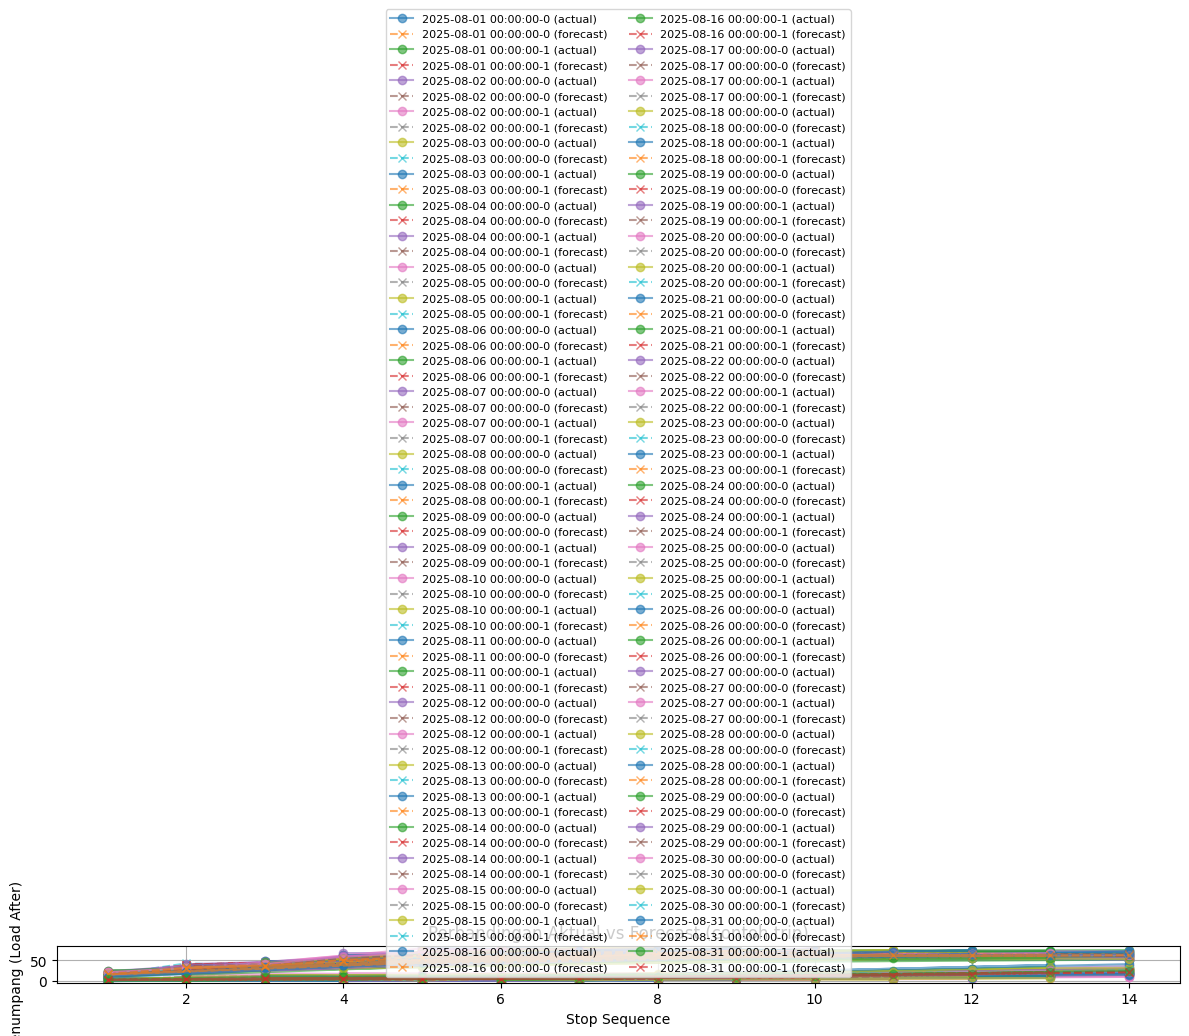

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Load hasil forecast
df = pd.read_excel("../modelling/hasil_forecast.xlsx")

# Pastikan kolom yang dipakai ada
cols = df.columns.str.lower()
col_actual = [c for c in df.columns if "load_after" in c.lower()][0]
col_forecast = [c for c in df.columns if "forecast" in c.lower()][0]

# Plot aktual vs prediksi untuk beberapa trip_date + direction
sample = df.groupby(["trip_date","direction"]).head(20)  # ambil 20 halte pertama per trip

plt.figure(figsize=(12,6))
for (trip_date, direction), grp in sample.groupby(["trip_date","direction"]):
    plt.plot(grp["stop_seq"], grp[col_actual], marker="o", label=f"{trip_date}-{direction} (actual)", alpha=0.6)
    plt.plot(grp["stop_seq"], grp[col_forecast], marker="x", linestyle="--", label=f"{trip_date}-{direction} (forecast)", alpha=0.6)

plt.xlabel("Stop Sequence")
plt.ylabel("Penumpang (Load After)")
plt.title("Perbandingan Aktual vs Forecast (contoh trip)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Baca hasil forecast
df_forecast = pd.read_excel("../modelling/hasil_forecast.xlsx")

# Pastikan kolom yang diperlukan ada
y_true = df_forecast["load_after"].astype(float)
y_pred = df_forecast["forecast"].astype(float)

# Hitung metrik
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

mae, rmse, r2

(5.321688129542267, 7.568548569655241, 0.9238364227201555)

In [ ]:
"""print("📈 Hasil forecast untuk", EXCEL_PATH)
display(df_forecast.head(20))   # 20 baris pertama
"""

📈 Hasil forecast untuk corridor1_august_2025.xlsx


,trip_date,direction,direction_label,stop_seq,stop_name,arr_time_wib,dep_time_wib,dwell_s,board,alight,...,cap,hour,dow,is_weekend,direction_num,prev_load,load_prior,board_prior,alight_prior,forecast
0,2025-08-01,0,BlokM→Kota,1,Blok M,2025-08-01T05:00:00+07:07,2025-08-01T05:00:29+07:07,29,14,0,...,80,0,0,0,0,0,0,0,0,8
1,2025-08-01,0,BlokM→Kota,2,ASEAN,2025-08-01T05:03:37.824594+07:07,2025-08-01T05:04:12.824594+07:07,35,17,3,...,80,0,0,0,0,0,0,0,0,8
2,2025-08-01,0,BlokM→Kota,3,Kejaksaan Agung,2025-08-01T05:07:45.287531+07:07,2025-08-01T05:08:18.287531+07:07,33,7,2,...,80,0,0,0,0,0,0,0,0,8
3,2025-08-01,0,BlokM→Kota,4,Masjid Agunng,2025-08-01T05:12:14.909795+07:07,2025-08-01T05:12:55.909795+07:07,41,8,0,...,80,0,0,0,0,0,0,0,0,8
4,2025-08-01,0,BlokM→Kota,5,Bundaran Senayan,2025-08-01T05:16:08.366837+07:07,2025-08-01T05:16:47.366837+07:07,39,10,1,...,80,0,0,0,0,0,0,0,0,8
5,2025-08-01,0,BlokM→Kota,6,Gelora Bung Karno,2025-08-01T05:19:48.448954+07:07,2025-08-01T05:20:22.448954+07:07,34,10,2,...,80,0,0,0,0,0,0,0,0,8
6,2025-08-01,0,BlokM→Kota,7,Polda Metro Jaya,2025-08-01T05:23:40.650035+07:07,2025-08-01T05:24:09.650035+07:07,29,4,0,...,80,0,0,0,0,0,0,0,0,8
7,2025-08-01,0,BlokM→Kota,8,Bendungan Hilir,2025-08-01T05:27:19.108411+07:07,2025-08-01T05:27:55.108411+07:07,36,9,3,...,80,0,0,0,0,0,0,0,0,8
8,2025-08-01,0,BlokM→Kota,9,Karet,2025-08-01T05:31:10.844722+07:07,2025-08-01T05:31:51.844722+07:07,41,8,5,...,80,0,0,0,0,0,0,0,0,8
9,2025-08-01,0,BlokM→Kota,10,Dukuh Atas 1,2025-08-01T05:35:27.579788+07:07,2025-08-01T05:36:12.579788+07:07,45,7,8,...,80,0,0,0,0,0,0,0,0,8


In [100]:
# Sesuaikan nama kolom dengan yang ada: arr_time, dep_time (bukan *_wib), dan tidak ada stop_name di file ini
# Jadi kita drop stop_name dari output

# Pilih 3 tanggal tidak berurutan
unique_dates = sorted(df["trip_date"].dropna().unique())
chosen_dates = [unique_dates[0], unique_dates[len(unique_dates)//2], unique_dates[-1]]

subset = df[df["trip_date"].isin(chosen_dates)][[
    "direction","stop_seq","arr_time","dep_time",
    "dwell_s","load_after","cap","forecast"
]]

# Simpan ke CSV baru
out_path = "../modelling/forecast_sampled.csv"
subset.to_csv(out_path, index=False)
out_path


'../modelling/forecast_sampled.csv'

In [200]:
OUT_PATH = "forecast_corridor1_august_2025.csv"
df_forecast.to_csv(OUT_PATH, index=False)
print("✅ Disimpan ke", OUT_PATH)


✅ Disimpan ke forecast_corridor1_august_2025.csv


In [205]:
# Baca file forecast_corridor1_august_2025.csv yang sudah diupload user
import pandas as pd

file_path = "../modelling/forecast_corridor1_august_2025.csv"
df_tes = pd.read_csv(file_path)

df_tes.shape


(47058, 22)

In [206]:
df_tes.columns

Index(['trip_date', 'direction', 'stop_seq', 'stop_name', 'arr_time_wib',
       'dep_time_wib', 'dwell_s', 'board', 'alight', 'load_before',
       'load_after', 'cap', 'stop_idx', 'hour', 'dow', 'is_weekend',
       'direction_num', 'prev_load', 'load_prior', 'board_prior',
       'alight_prior', 'forecast'],
      dtype='object')